# Data Wrangling

##Assesing the data

In [ ]:
try:
    # Standard imports
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

    # Google Colab specific
    from google.colab import drive

    # NLP libraries
    import nltk
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer

    # Additional libraries
    import re
    from collections import Counter
    import pandas as pd
    from tqdm import tqdm
    import pycountry
    from geotext import GeoText

except ImportError as e:
    print(f"Error: {e}")
    print("Attempting to install missing packages...")

    # Install missing libraries
#    !pip install geotext
#    !pip install pycountry
#    !pip install nltk tqdm matplotlib seaborn
    print("Re-run the code after successful installations.")



Error: No module named 'pycountry'
Attempting to install missing packages...
Re-run the code after successful installations.


In [ ]:
drive.mount('/content/drive')
df =pd.read_csv('/content/drive/My Drive/Data mining Project/un_news_2019_2024_combined.csv')

Mounted at /content/drive


In [ ]:
df.sample(1)

,title,url,datetime,region,content
2956,UN envoy reports on progress towards Yemen pea...,https://news.un.org/en/story/2023/05/1136752,2023-05-17T12:00:00Z,Middle East,Warring parties continue to make progress in e...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194 entries, 0 to 3193
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     3194 non-null   object
 1   url       3194 non-null   object
 2   datetime  3194 non-null   object
 3   region    2838 non-null   object
 4   content   3186 non-null   object
dtypes: object(5)
memory usage: 124.9+ KB


In [ ]:
df.describe().T

,count,unique,top,freq
title,3194,3193,5 ways UN Peacekeeping partnerships drive peac...,2
url,3194,3194,https://news.un.org/en/story/2019/12/1054401,1
datetime,3194,1433,2019-09-26T12:00:00Z,8
region,2838,6,Africa,915
content,3186,3185,"Every day, United Nations peacekeepers work to...",2


In [ ]:
df['title'].duplicated().sum()

1

In [ ]:
df[df.duplicated(keep=False, subset=['title', 'content'])]

,title,url,datetime,region,content
2146,5 ways UN Peacekeeping partnerships drive peac...,https://news.un.org/en/story/2022/05/1119212,2022-05-28T12:00:00Z,Global,"Every day, United Nations peacekeepers work to..."
2150,5 ways UN Peacekeeping partnerships drive peac...,https://news.un.org/en/story/2022/05/1119112,2022-05-26T12:00:00Z,Global,"Every day, United Nations peacekeepers work to..."


In [ ]:
df.isnull().sum()

,0
title,0
url,0
datetime,0
region,356
content,8


## Summary of Accesing the data

#### Issues Identified
1. **Erroneous Data Type**: The `datetime` column is stored as a string instead of in `datetime` format.  
2. **Null Values**:
   - 356 missing values in the `region` column.  
   - 356 missing values in the `content` column (8 out of 3193 records, ~0.25%).  
3. **Duplicate Value**: A single duplicate value exists in the dataset.  
4. **Text Cleaning**: The text contains punctuations and underscores, which need to be removed for word-level analysis.  
#### Resolution Steps
1. Convert the `datetime` column from string to `datetime` format.  
2. Address null values in the `region` column by analyzing the `title` and extracting the relevant region.  
3. Handle null values in the `content` column by dropping the rows with missing values since they constitute a negligible percentage (~0.25%).  
4. Remove the duplicate record from the dataset.  
5. Clean the text data by removing punctuations and underscores to prepare it for word-level analysis.

## Cleaning

*make a copy of the dataframe*

In [ ]:
#create a copy of the df
df_copy=df.copy()

*datatype, null values and duplicate issues*

In [ ]:
#change date data type
df_copy['datetime']=pd.to_datetime(df_copy['datetime'])
#drop null values
df_copy = df_copy.dropna(subset=['content'])
#drop duplicates
df_copy=df_copy.drop_duplicates(subset=['title', 'content'])

#### **replacing null values in the region column**

- we look up country name in the title column and assign it to a new region
- we filll the null values with its corresponding values in the new region generated

In [ ]:

# Define a custom function to map countries to specific regions
def country_to_custom_region(country_name):
    # Custom mapping for alternate and complex country names
    alternate_country_names = {
        "Central African Republic": "CF",
        "Democratic Republic of the Congo": "CD",
        "Syria": "SY",
        "Armenia-Azerbaijan": "AM-AZ",
        "Russia": "RU",
        "Ukraine": "UA",
        "Palestine": "PS",  # Explicitly add Palestine
        "Mozambique": "MZ",
        "Yemen": "YE",
        "Nigeria": "NG",
        "Israel": "IL",  # Explicitly add Israel
        "Hong Kong": "HK",  # Special case for Hong Kong (SAR of China)
        "Venezuela": "VE",
        "Haiti": "HT"
    }

    # Map regions with country codes
    region_map = {
        'Africa': ['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'KM', 'CG', 'CD', 'DJ', 'EG', 'GQ', 'ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'CI', 'KE', 'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'MA', 'MZ', 'NA', 'NE', 'NG', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'ZA', 'SS', 'SD', 'SZ', 'TZ', 'TG', 'TN', 'UG', 'EH', 'ZM', 'ZW'],
        'Americas': ['AG', 'BS', 'BB', 'BZ', 'CA', 'CR', 'CU', 'DM', 'DO', 'SV', 'GD', 'GT', 'GY', 'HT', 'HN', 'JM', 'MX', 'NI', 'PA', 'KN', 'LC', 'VC', 'TT', 'US', 'AR', 'BO', 'BR', 'CL', 'CO', 'EC', 'PY', 'PE', 'SR', 'UY', 'VE'],
        'Asia Pacific': ['AF', 'AM', 'AZ', 'BD', 'BT', 'BN', 'KH', 'CN', 'FJ', 'ID', 'IN', 'JP', 'KZ', 'KG', 'LA', 'MY', 'MV', 'MN', 'MM', 'NP', 'NZ', 'KP', 'PK', 'PG', 'PH', 'SG', 'KR', 'LK', 'TJ', 'TH', 'TL', 'TM', 'UZ', 'VN', 'WS', 'SB', 'TO', 'TV', 'VU', 'AU'],
        'Middle East': ['BH', 'CY', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'QA', 'SA', 'SY', 'TR', 'AE', 'YE'],
        'Europe': ['AL', 'AD', 'AT', 'BY', 'BE', 'BA', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'LV', 'LI', 'LT', 'LU', 'MT', 'MD', 'MC', 'ME', 'NL', 'MK', 'NO', 'PL', 'PT', 'RO', 'RU', 'SM', 'RS', 'SK', 'SI', 'ES', 'SE', 'CH', 'UA', 'GB']
    }

    # Check for alternate country names before proceeding to geo-text and pycountry
    country_name = alternate_country_names.get(country_name, country_name)

    country_alpha_2 = None

    # Get country object from pycountry
    try:
        country_obj = pycountry.countries.lookup(country_name)
        country_alpha_2 = country_obj.alpha_2
    except LookupError:
        return "Unknown", "Unknown"  # In case country is not found

    # Search for the country in the region map
    for region, country_codes in region_map.items():
        if country_alpha_2 in country_codes:
            return country_name, region
    return "Unknown", "Unknown"


In [ ]:
# Function to map Palestine to the Middle East region
def map_palestine_to_region(text):
    # Check if "Palestine" or "Gaza" is mentioned explicitly in the text
    if "Palestine" in text or "Gaza" in text or "Palestinian" in text:
        return "Palestine", "Middle East"

    # If Palestine is not found, continue with other country detection
    return extract_country_and_region(text)



# Function to check for a region name in the text and map it directly
def map_region_from_text(text):
    region_keywords = {
        "Middle East": "Middle East",
        "Africa": "Africa",
        "Americas": "Americas",
        "Asia Pacific": "Asia Pacific",
        "Europe": "Europe"
    }

    # Check if any region keyword is in the text
    for region_name, region in region_keywords.items():
        if region_name.lower() in text.lower():  # Case-insensitive matching
            return "Unknown", region  # Country is unknown, but region is detected

    return None  # No region found

# Extract country names and map to custom regions
def extract_country_and_region(text):
    # First, explicitly handle the case for "Palestine"
    if "Palestine" in text or "Gaza" in text or "Palestinian" in text:
        return map_palestine_to_region(text)

    # Handle special cases directly in the text
    special_cases = {
        "DR Congo": "Democratic Republic of the Congo",
        "Russia": "Russia",
        "Ukraine": "Ukraine",
        "Central African Republic": "Central African Republic",
        "Syria": "Syria",
        "Mozambique": "Mozambique",
        "Yemen": "Yemen",
        "Nigeria": "Nigeria",
        "Israel": "Israel",
        "Hong Kong": "Hong Kong",  # Special case for Hong Kong (SAR of China)
        "Venezuela": "Venezuela",
        "Haiti": "Haiti",
        "Israel-Palestine": "Israel-Palestine",  # Handle Israel-Palestine together
        "Armenia-Azerbaijan": "Armenia-Azerbaijan",  # Special case for multi-country
        "Tigray": "Ethiopia",  # Map Tigray to Ethiopia
        "Iraq": "Iraq",  # Handle Iraq explicitly
        "Algerians": "Algeria",  # Handle "Algerians" explicitly
        "Afghan": "Afghanistan",  # Handle "Afghan" explicitly
        "Somali": "Somalia",  # Handle "Somali" explicitly
        "Libya": "Libya",  # Handle Libya explicitly
        "Mosul": "Iraq",  # Mosul is in Iraq, so map it to Iraq
        "League of Arab States": "Middle East"  # Handle Arab League
    }

    # Check if any special cases exist
    for abbreviation, full_name in special_cases.items():
        if abbreviation in text:
            return country_to_custom_region(full_name)

    # Check if a region name is directly mentioned
    region_mapping = map_region_from_text(text)
    if region_mapping:
        return region_mapping

    # Use GeoText to extract countries from the text
    places = GeoText(text)
    countries = places.countries
    if not countries:
        return "Unknown", "Unknown"

    # Use the first detected country and map it to a region
    country_name = countries[0]
    return country_to_custom_region(country_name)

#applying it to the DataFrame
df_copy[['country', 'region_new']] = df_copy['title'].apply(lambda x: pd.Series(extract_country_and_region(x)))


In [ ]:
df_copy['region_clean'] = df_copy['region'].fillna(df_copy['region_new'])

In [ ]:
print(len(df_copy[['country','title']][df_copy['region_clean']=='Unknown']))
pd.set_option('display.max_colwidth', None)
display(df_copy[['country','title']][df_copy['region_clean']=='Unknown'][:54])
pd.reset_option('display.max_colwidth')

114


,country,title
66,Unknown,UN updates guidelines to ensure successful return to civilian life for former combatants
108,Unknown,"Reparations for sexual violence in conflict – ‘what survivors want most, yet receive least’"
118,Unknown,"Protests around the world: Politicians must address ‘growing deficit of trust’, urges Guterres"
157,Unknown,"Historic first, as Tolstoy’s War and Peace lands in Geneva, to mark international centenary"
167,Unknown,"Peace icon Mahatma Gandhi’s message of ‘mutual understanding, equality’ reverberates on Day of Non-Violence"
186,Unknown,"Elimination of nuclear weapons ‘only real way’ to allay fear of a constant threat, Guterres insists"
213,Unknown,Guterres calls for ‘maximum restraint’ following drone assault on key Saudi oil facility
282,Unknown,"Tuesday’s Daily Brief: Hong Kong airport disruption, Geneva Conventions at 70, new Ebola drug, French fighters in Iraq, Mediterranean migrant and Aden updates"
329,Unknown,"‘Deep sadness’ at passing of UN nuclear watchdog agency chief, Yukiya Amano"
350,Unknown,"Threat from petty criminals who turn to terrorism, a growing concern, Security Council hears"


In [ ]:
df_copy['region_clean'].value_counts()

,count
region_clean,
Africa,987
Middle East,808
Global,473
Europe,348
Asia Pacific,305
Americas,150
Unknown,114


#### **text cleaning**

*function to clean text*

In [ ]:
# Create a function to clean the content
def cleanTxt(text, remove_numbers=False, remove_stopwords=False):
    # Convert text to lowercase
    text = text.lower()
    # Remove underscores
    text = re.sub(r'_', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = re.sub(r'[^\w\s-]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [ ]:
# Apply the function to the 'content' column
df_copy['content_clean'] = df_copy['title'].apply(cleanTxt)


In [ ]:
#extract only relevant columns for exploration
df_copy=df_copy[['datetime','country', 'region_clean','title','content', 'content_clean', 'url']]

In [ ]:
# Using .split() to split the text by spaces
df_copy['content_clean'] = df_copy['content_clean'].apply(lambda x: x.split())


In [ ]:
# Download the NLTK stopwords list
nltk.download('stopwords')

In [ ]:
# Get the list of stopwords in English
stop_words = set(stopwords.words('english'))

# Remove stopwords from 'content_clean' column
df_copy['content_clean'] = df_copy['content_clean'].apply(lambda x: [word for word in x if word.lower() not in stop_words])



In [ ]:

# Download the NLTK WordNet dataset
nltk.download('wordnet')

# Initialize the lemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Now we can proceed with lemmatization
df_copy['content_clean'] = df_copy['content_clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

#### **time measures**



*function to transform date column into month, quarter and season*

In [ ]:
df_copy['datetime'] = pd.to_datetime(df_copy['datetime'], errors='coerce')


# Extract the month name
df_copy['month'] = df_copy['datetime'].dt.strftime('%B')

# Define a function to categorize seasons based on the month
def get_season(month):
    if month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Autumn'
    else:
        return 'Winter'

# Apply the function to create a season column
df_copy['season'] = df_copy['month'].apply(get_season)

# Extract the quarter (Q1, Q2, Q3, Q4)
df_copy['quarter'] = df_copy['datetime'].dt.quarter

# Extract the year
df_copy['year'] = df_copy['datetime'].dt.year




In [ ]:
df_copy.sample(1)

,datetime,country,region_clean,title,content,content_clean,url,month,season,quarter,year
237,2019-09-03 12:00:00+00:00,Myanmar,Asia Pacific,UN experts decry torture of Rakhine men and bo...,Allegations of torture and ill-treatment leadi...,"[un, expert, decry, torture, rakhine, men, boy...",https://news.un.org/en/story/2019/09/1045442,September,Autumn,3,2019


# Sentimental Models

Before we begin the exploratory data analysis, it's essential to incorporate the sentiment from each text, as sentiment will be a key component of our exploration. To do this, we will introduce our sentiment analysis models and apply them to the data.

## VADER (Valence Aware Dictionary and sEntiment Reasoner):
- **VADER** is specifically designed for **sentiment analysis**, and it works well without requiring stopword removal or lemmatization. This is because VADER relies on a lexicon of pre-defined words with sentiment scores (positive, negative, and neutral). It's particularly useful for analyzing short texts.
## RoBERTa (Robustly optimized BERT approach):
- **RoBERTa**, is a **pretrained transformer-based model** for a wide range of NLP tasks. While **RoBERTa** itself does not require stopword removal or lemmatization to achieve high performance, it's important to note that the model is trained on large corpora of text and has learned semantic representations that capture meaning directly from context.
  

Both **VADER** and **RoBERTa** can perform well without the need for stopword removal or lemmatization because they are designed to handle raw text effectively.



In [ ]:
# for Vader
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')


#for Roberta
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
#insert id in the dataframe
df_copy.insert(0, 'Id', range(1, len(df_copy) + 1))


In [ ]:
#Vader
sia = SentimentIntensityAnalyzer()
#Roberta
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
#Roberta Polarity Score
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
def comparescores(text):
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}
    roberta_result = polarity_scores_roberta(text)
    return {**vader_result_rename, **roberta_result}


In [ ]:
# Define the comparescores function
def comparescores(text):
    # VADER Sentiment Analysis
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

    # RoBERTa Sentiment Analysis
    roberta_result = polarity_scores_roberta(text)

    # Combine both results
    return {**vader_result_rename, **roberta_result}

# Select 5 random rows and apply the function on the 'content' column
sample_df = df_copy.sample(n=5, random_state=5)  # Randomly sample 5 rows

# Print each text and its respective scores
for i, row in sample_df.iterrows():
    print("title:", row['title'], "\n")
    scores = comparescores(row['title'])
    print("Scores:")
    for score_name, score_value in scores.items():
        print(f"  {score_name}: {score_value}")
    print("\n" + "-"*50 + "\n")


title: #UNGA NEWS ROUNDUP: Funding plea for UNRWA, Burkina Faso and CAR updates, Guterres praises climate change ‘pioneer’ Chirac 

Scores:
  vader_neg: 0.0
  vader_neu: 0.833
  vader_pos: 0.167
  vader_compound: 0.5267
  roberta_neg: 0.03526866436004639
  roberta_neu: 0.8017715811729431
  roberta_pos: 0.1629597395658493

--------------------------------------------------

title: Another sombre milestone for Afghanistan: 2018 saw record civilian deaths – UN report 

Scores:
  vader_neg: 0.0
  vader_neu: 1.0
  vader_pos: 0.0
  vader_compound: 0.0
  roberta_neg: 0.5932051539421082
  roberta_neu: 0.3799733817577362
  roberta_pos: 0.02682146057486534

--------------------------------------------------

title: Iraq: Investigative team reaches ‘next level’ in bid to bring ISIL terrorists to justice 

Scores:
  vader_neg: 0.208
  vader_neu: 0.558
  vader_pos: 0.234
  vader_compound: -0.128
  roberta_neg: 0.10310488194227219
  roberta_neu: 0.827237606048584
  roberta_pos: 0.06965743005275726



Warning: Please proceed with caution when running the code below. It executes both VADER and RoBERTa, which are powerful models and may not be ideal for local machines due to their resource-intensive nature.

In [ ]:
'''

batch_size = 500  # Adjust as needed
num_batches = len(df_copy) // batch_size + 1  # Calculate number of batches

all_results = []  # List to store DataFrames for each batch

for batch_num in range(num_batches):
    batch_start = batch_num * batch_size
    batch_end = (batch_num + 1) * batch_size
    batch_data = df_copy.iloc[batch_start:batch_end]

    res = {}  # Reset the results for each batch

    for i, row in tqdm(batch_data.iterrows(), total=len(batch_data), desc=f"Processing Batch {batch_num + 1}"):
        try:
            text = row['title']
            if not isinstance(text, str):
                text = str(text) if text is not None else ''
            myid = row['Id']

            # VADER Sentiment Analysis
            vader_result = sia.polarity_scores(text)
            vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

            # RoBERTa Sentiment Analysis
            roberta_result = polarity_scores_roberta(text)

            # Combine results
            both = {**vader_result_rename, **roberta_result}
            res[myid] = both

        except RuntimeError:
            print(f'Error processing id {myid} in batch {batch_num + 1}')

    # Convert the results dictionary to a DataFrame
    batch_results_df = pd.DataFrame.from_dict(res, orient='index')
    batch_results_df.index.name = 'Id'

    # Append batch_results_df to the list of all results
    all_results.append(batch_results_df)
    print(f"Finished batch {batch_num + 1}/{num_batches}")

# Concatenate all batch results into a single DataFrame
results_df = pd.concat(all_results)

# Merge results back into df_copy on the 'Id' column
df_copy = df_copy.merge(results_df, left_on='Id', right_index=True, how='left')

# Now df_copy contains the sentiment scores for each content


Processing Batch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Finished batch 1/7


Processing Batch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Finished batch 2/7


Processing Batch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Finished batch 3/7


Processing Batch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Finished batch 4/7


Processing Batch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Finished batch 5/7


Processing Batch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Finished batch 6/7


Processing Batch 7:   0%|          | 0/185 [00:00<?, ?it/s]

Finished batch 7/7


In [ ]:
# Define function to update the vader_predict column based on vader_compound value
def update_vader_predict(row):
    compound_score = row['vader_compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Define function to determine RoBERTa sentiment
def determine_roberta_sentiment(row):
    if row['roberta_pos'] > row['roberta_neg'] and row['roberta_pos'] > row['roberta_neu']:
        return 'positive'
    elif row['roberta_neg'] > row['roberta_pos'] and row['roberta_neg'] > row['roberta_neu']:
        return 'negative'
    else:
        return 'neutral'

# Apply the functions to create new columns
df_copy['vader_predict'] = df_copy.apply(update_vader_predict, axis=1)
df_copy['roberta_predict'] = df_copy.apply(determine_roberta_sentiment, axis=1)



In [ ]:

# Save the DataFrame to a CSV file
df_copy.to_csv('updated_roberta_vader.csv', index=False)

from google.colab import files
files.download('updated_roberta_vader.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploration


For the exploratory data analysis, we will follow a structured approach. First, we'll conduct univariate exploration to analyze individual features. Next, we'll move on to bivariate exploration to examine the relationships between two features. Finally, we'll perform multivariate exploration to explore interactions among multiple features.

In [ ]:
drive.mount('/content/drive')
df_copy =pd.read_csv('/content/drive/My Drive/Data mining Project/updated_roberta_vader.csv')

Mounted at /content/drive


## Univariate exploration

Exploration of individual variables



**REGION**




*Most news coverage on peace and security comes from Africa and the Middle East, while the Americas have the least coverage on this topic.*

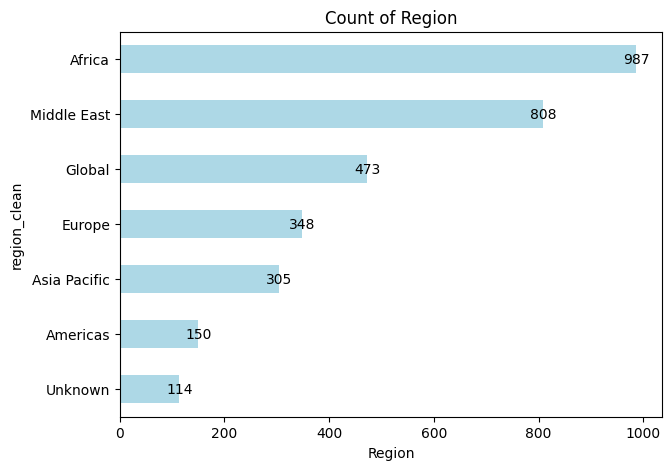

In [ ]:

# Create the plot
ax = df_copy['region_clean'].value_counts().sort_values(ascending=True) \
    .plot(kind='barh',
          title='Count of Region',
          figsize=(7,5), color='lightblue')

# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Set labels
ax.set_xlabel('Region')

# Add the value labels to each bar
for p in ax.patches:
    ax.text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2,
            f'{int(p.get_width())}', ha='center', va='center', color='black', fontsize=10)

# Show the plot
plt.show()


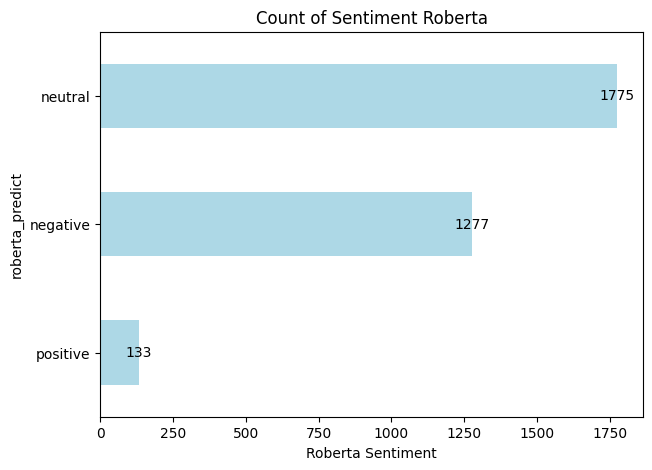

In [ ]:

# Create the plot
ax = df_copy['roberta_predict'].value_counts().sort_values(ascending=True) \
    .plot(kind='barh',
          title='Count of Sentiment Roberta',
          figsize=(7, 5), color='lightblue')

# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Set labels
ax.set_xlabel('Roberta Sentiment')

# Add the value labels to each bar
for p in ax.patches:
    ax.text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2,
            f'{int(p.get_width())}', ha='center', va='center', color='black', fontsize=10)

# Show the plot
plt.show()


**SENTIMENT COUNT**

*For RoBERTa, the sentiment distribution is 56% neutral, 40% negative, and 4% positive.*

*For VADER, the sentiment distribution is 17% neutral, 50% negative, and 33% positive.*

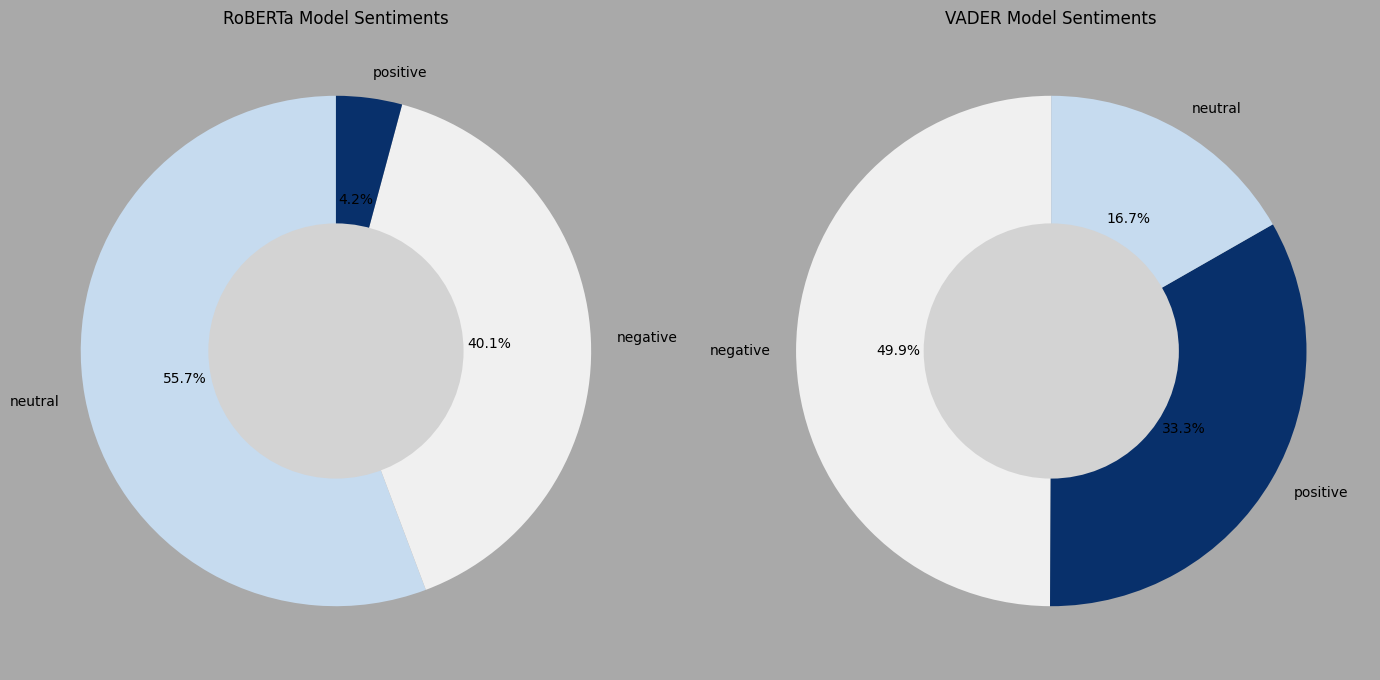

In [ ]:

# Count the occurrences of each sentiment prediction for RoBERTa and VADER
roberta_counts = df_copy['roberta_predict'].value_counts()
vader_counts = df_copy['vader_predict'].value_counts()

# Define consistent color mapping for sentiments
color_mapping = {
    'positive': '#08306b',  #
    'neutral': '#c6dbef',   #
    'negative': '#f0f0f0'   #
}

# Create subplots for RoBERTa and VADER pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# RoBERTa Pie Chart with percentage labels and fixed colors
roberta_counts.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90, colors=[color_mapping[label] for label in roberta_counts.index])
axes[0].add_artist(plt.Circle((0, 0), 0.50, fc='lightgrey'))  # Draw circle for donut chart
axes[0].set_title('RoBERTa Model Sentiments')
axes[0].axis('off')  # Turn off the axis for the pie chart

# VADER Pie Chart with percentage labels and fixed colors
vader_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90, colors=[color_mapping[label] for label in vader_counts.index])
axes[1].add_artist(plt.Circle((0, 0), 0.50, fc='lightgrey'))  # Draw circle for donut chart
axes[1].set_title('VADER Model Sentiments')
axes[1].axis('off')  # Turn off the axis for the pie chart

# Set background color for both axes and figure
axes[0].set_facecolor('darkgray')  # Axes background color for RoBERTa chart
axes[1].set_facecolor('darkgray')  # Axes background color for VADER chart
plt.gcf().set_facecolor('darkgray')  # Figure background color

# Display the charts
plt.tight_layout()
plt.show()


### word level analysis

*Most of the content falls within the 5 to 15-word range.*

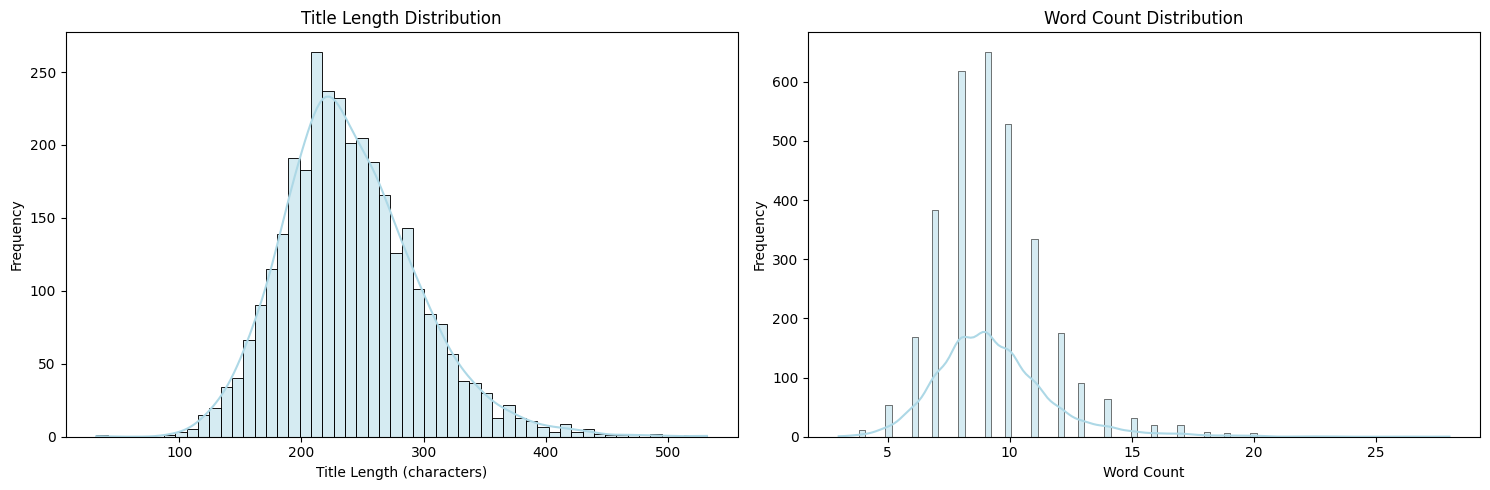

In [ ]:
# Calculate Content Length (in characters)
df_copy['content_length'] = df_copy['content'].apply(len)

# Calculate Word Count (in words)
df_copy['word_count'] = df_copy['content_clean'].apply(len)

# Plotting Content Length and Word Count Distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Content Length Distribution
ax=sns.histplot(df_copy['content_length'], kde=True, color='lightblue', ax=axes[0])
axes[0].set_title('Title Length Distribution')
axes[0].set_xlabel('Title Length (characters)')
axes[0].set_ylabel('Frequency')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Word Count Distribution
ax=sns.histplot(df_copy['word_count'], kde=True, color='lightblue', ax=axes[1])
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Adjust layout and display
plt.tight_layout()
plt.show()


**TOP 10 MOST FREQUENT WORDS**

*While VADER and RoBERTa differ in their sentiment proportions, they share a remarkably similar set of most frequent words. Notable distinctions between the two include terms like *war*, *crisis*, and *council*.*

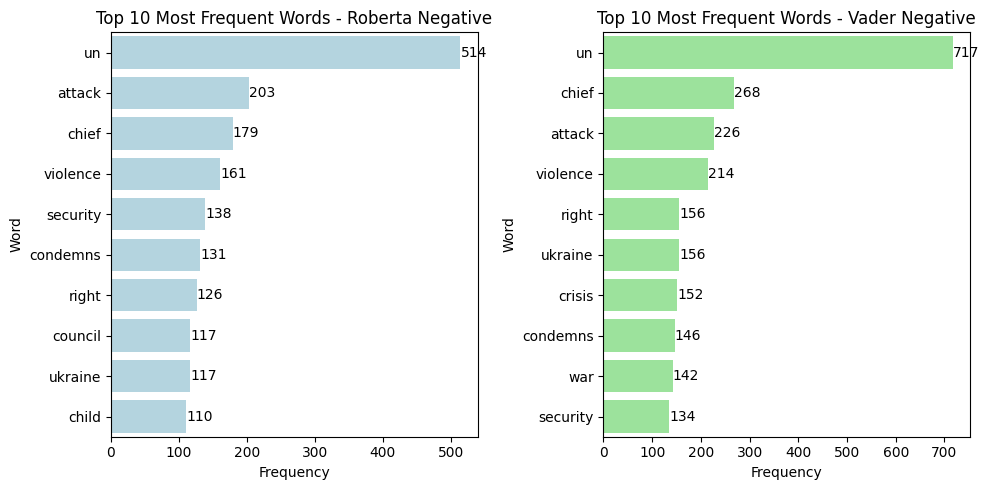

In [ ]:
# Filter negative predictions for both Roberta and Vader, and create copies to avoid SettingWithCopyWarning
roberta_negative = df_copy[df_copy['roberta_predict'] == 'negative'].copy()
vader_negative = df_copy[df_copy['vader_predict'] == 'negative'].copy()

import ast

# Cleaning the string representation to ensure proper conversion
roberta_negative['content_clean'] = roberta_negative['content_clean'].apply(
    lambda x: ast.literal_eval(x.replace("'", "\"")) if isinstance(x, str) else x
)

vader_negative['content_clean'] = vader_negative['content_clean'].apply(
    lambda x: ast.literal_eval(x.replace("'", "\"")) if isinstance(x, str) else x
)

# Function to calculate word frequencies
from collections import Counter

def get_top_words(data, column, top_n=10):
    all_words = [word for content in data[column] for word in content]
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Get the top 10 words for Roberta and Vader
top_10_roberta = get_top_words(roberta_negative, 'content_clean', top_n=10)
top_10_vader = get_top_words(vader_negative, 'content_clean', top_n=10)

# Create DataFrames for easier plotting
top_10_roberta_df = pd.DataFrame(top_10_roberta, columns=['Word', 'Frequency'])
top_10_vader_df = pd.DataFrame(top_10_vader, columns=['Word', 'Frequency'])

# Create subplots to display the charts side by side
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot Roberta negative word frequencies
ax_roberta = sns.barplot(x='Frequency', y='Word', data=top_10_roberta_df, ax=axes[0], color='lightblue')
axes[0].set_title('Top 10 Most Frequent Words - Roberta Negative')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Word')

# Annotate bars with counts for Roberta
for index, row in top_10_roberta_df.iterrows():
    axes[0].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Plot Vader negative word frequencies
ax_vader = sns.barplot(x='Frequency', y='Word', data=top_10_vader_df, ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Most Frequent Words - Vader Negative')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

# Annotate bars with counts for Vader
for index, row in top_10_vader_df.iterrows():
    axes[1].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


**BIGRAMS AND TRIGRAMS**

*Similar to the most frequent words in VADER and RoBERTa, the bigrams and trigrams also exhibit comparable patterns.*

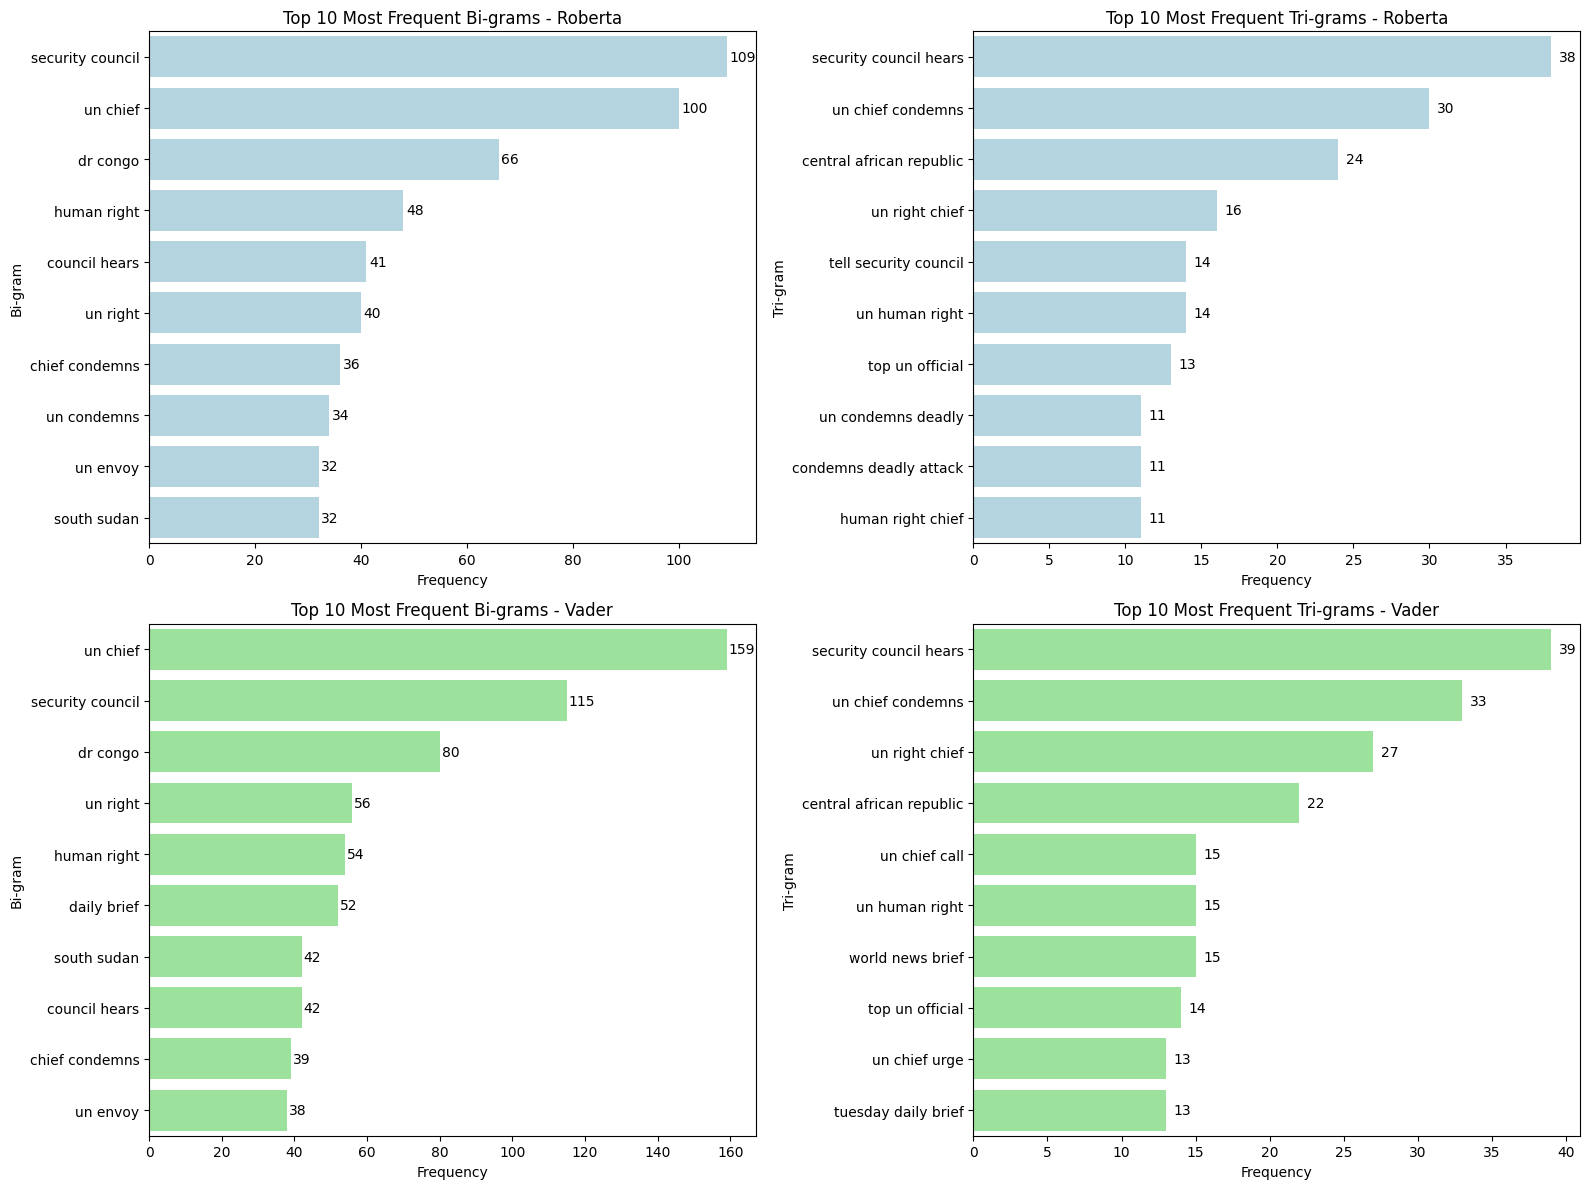

In [ ]:
from nltk.util import ngrams


# Define function to generate and count n-grams
def get_top_ngrams(corpus, n=2, top_n=10):
    ngram_counts = Counter()
    for content in corpus:
        ngram_counts.update(ngrams(content, n))
    return ngram_counts.most_common(top_n)

# Get top 10 bi-grams and tri-grams for Roberta
top_10_bigrams_roberta = get_top_ngrams(roberta_negative['content_clean'], n=2)
top_10_trigrams_roberta = get_top_ngrams(roberta_negative['content_clean'], n=3)

# Get top 10 bi-grams and tri-grams for Vader
top_10_bigrams_vader = get_top_ngrams(vader_negative['content_clean'], n=2)
top_10_trigrams_vader = get_top_ngrams(vader_negative['content_clean'], n=3)

# Convert to DataFrames for easy plotting
top_10_bigrams_roberta_df = pd.DataFrame(top_10_bigrams_roberta, columns=['N-gram', 'Frequency'])
top_10_trigrams_roberta_df = pd.DataFrame(top_10_trigrams_roberta, columns=['N-gram', 'Frequency'])
top_10_bigrams_vader_df = pd.DataFrame(top_10_bigrams_vader, columns=['N-gram', 'Frequency'])
top_10_trigrams_vader_df = pd.DataFrame(top_10_trigrams_vader, columns=['N-gram', 'Frequency'])

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Roberta Bi-grams
ax = sns.barplot(
    x='Frequency',
    y=[' '.join(ngram) for ngram in top_10_bigrams_roberta_df['N-gram']],
    data=top_10_bigrams_roberta_df, color='lightblue', ax=axes[0, 0]
)
axes[0, 0].set_title('Top 10 Most Frequent Bi-grams - Roberta')
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_ylabel('Bi-gram')
# Add annotations
for index, row in top_10_bigrams_roberta_df.iterrows():
    axes[0, 0].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Roberta Tri-grams
ax = sns.barplot(
    x='Frequency',
    y=[' '.join(ngram) for ngram in top_10_trigrams_roberta_df['N-gram']],
    data=top_10_trigrams_roberta_df, color='lightblue', ax=axes[0, 1]
)
axes[0, 1].set_title('Top 10 Most Frequent Tri-grams - Roberta')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('Tri-gram')
# Add annotations
for index, row in top_10_trigrams_roberta_df.iterrows():
    axes[0, 1].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Vader Bi-grams
ax = sns.barplot(
    x='Frequency',
    y=[' '.join(ngram) for ngram in top_10_bigrams_vader_df['N-gram']],
    data=top_10_bigrams_vader_df, color='lightgreen', ax=axes[1, 0]
)
axes[1, 0].set_title('Top 10 Most Frequent Bi-grams - Vader')
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_ylabel('Bi-gram')
# Add annotations
for index, row in top_10_bigrams_vader_df.iterrows():
    axes[1, 0].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Vader Tri-grams
ax = sns.barplot(
    x='Frequency',
    y=[' '.join(ngram) for ngram in top_10_trigrams_vader_df['N-gram']],
    data=top_10_trigrams_vader_df, color='lightgreen', ax=axes[1, 1]
)
axes[1, 1].set_title('Top 10 Most Frequent Tri-grams - Vader')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Tri-gram')
# Add annotations
for index, row in top_10_trigrams_vader_df.iterrows():
    axes[1, 1].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


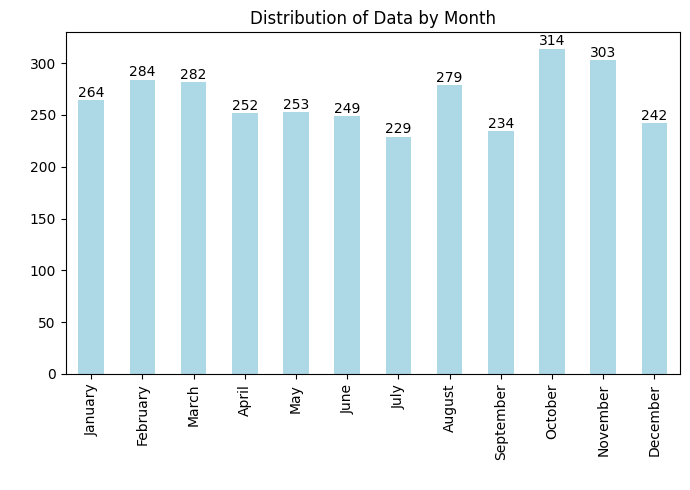

In [ ]:
# Create the plot using pandas value_counts for month distribution (vertical bar plot)
ax = df_copy['month'].value_counts().sort_index() \
    .plot(kind='bar',  # Change to 'bar' for vertical bars
          title='Distribution of Data by Month',
          figsize=(7, 5), color='lightblue')

# Set labels
ax.set_xlabel('Frequency', fontsize=10, color='white')  # Label for the x-axis
ax.set_ylabel('Month', fontsize=10, color='white')  # Label for the y-axis

# Add value labels to each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.2,
            f'{int(p.get_height())}', ha='center', va='bottom', color='black', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


**Yearly Trend**  

There was a noticeable decline in the volume of news content during 2020 and 2021.

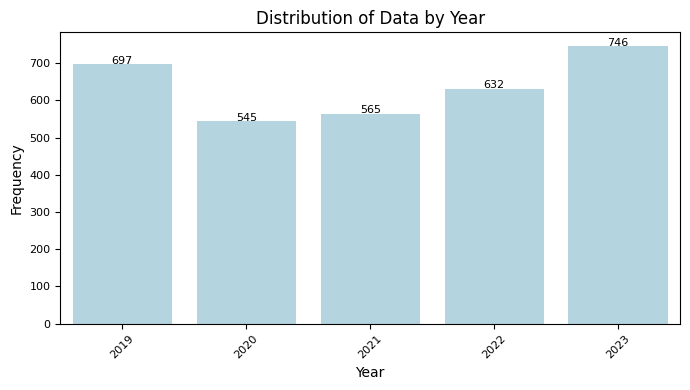

In [ ]:
plt.figure(figsize=(7, 4))

# Create the count plot for the distribution of years
ax = sns.countplot(x='year', data=df_copy, color='lightblue')  # Set the same color for all bars

# Annotate each bar with its frequency
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # Center the text horizontally
        y=height + 0.5,  # Slightly above the bar
        s=f'{int(height)}',  # Frequency value
        ha='center',  # Center align the text horizontally
        fontsize=8  # Font size for annotations
    )

# Set plot titles and labels
plt.title('Distribution of Data by Year', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


**Quarterly Trend**  

The majority of news content on peace and security is concentrated at the beginning and end of the year, specifically in the first and fourth quarters.

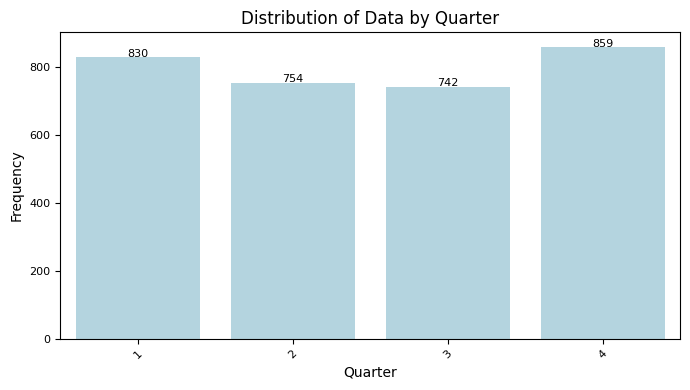

In [ ]:
plt.figure(figsize=(7, 4))

# Create the count plot for the distribution of quarters
ax = sns.countplot(x='quarter', data=df_copy, color='lightblue')  # Set the same color for all bars

# Annotate each bar with its frequency
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # Center the text horizontally
        y=height + 0.5,  # Slightly above the bar
        s=f'{int(height)}',  # Frequency value
        ha='center',  # Center align the text horizontally
        fontsize=8  # Font size for annotations
    )

# Set plot titles and labels
plt.title('Distribution of Data by Quarter', fontsize=12)
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


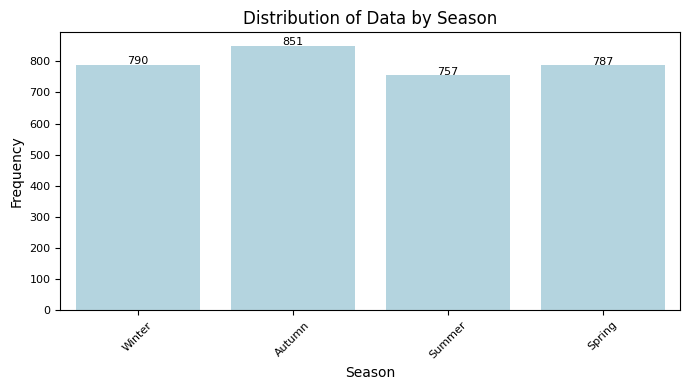

In [ ]:
plt.figure(figsize=(7, 4))

# Create the count plot for the distribution of quarters
ax = sns.countplot(x='season', data=df_copy, color='lightblue')  # Set the same color for all bars

# Annotate each bar with its frequency
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # Center the text horizontally
        y=height + 0.5,  # Slightly above the bar
        s=f'{int(height)}',  # Frequency value
        ha='center',  # Center align the text horizontally
        fontsize=8  # Font size for annotations
    )

# Set plot titles and labels
plt.title('Distribution of Data by Season', fontsize=12)
plt.xlabel('Season', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Bivariate Exploration

Exploration between 2 features

**Region vs Sentiment**  

Both models indicate that Africa and the Middle East exhibit the highest levels of negative sentiment.

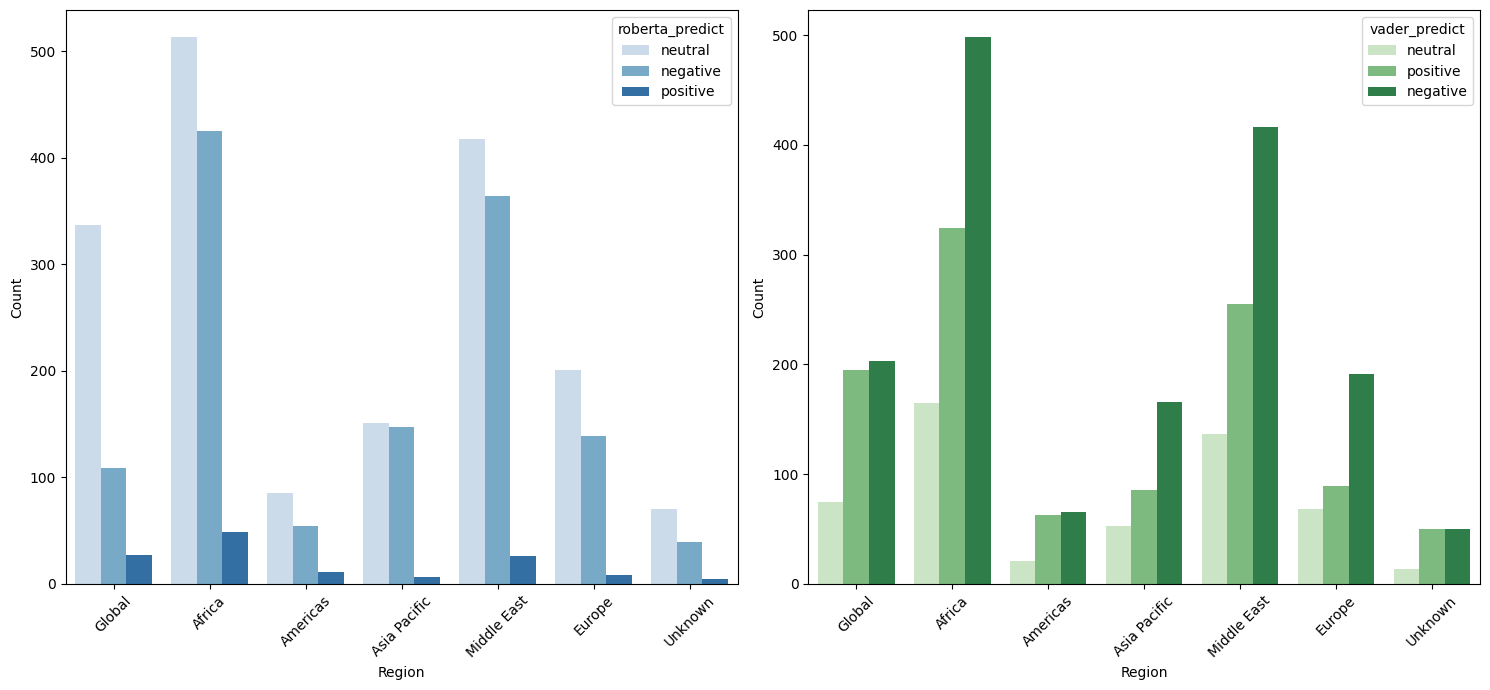

In [ ]:


plt.figure(figsize=[15, 7])

# Region by roberta sentiment count
plt.subplot(1, 2, 1)
ax=sns.countplot(data=df_copy, x='region_clean', hue='roberta_predict', palette='Blues')
plt.xlabel('Region')
plt.ylabel('Count')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Rotate the x-axis labels by 45 degrees for the first plot
plt.xticks(rotation=45)

# Region by vader sentiment count
plt.subplot(1, 2, 2)
ax=sns.countplot(data=df_copy, x='region_clean', hue='vader_predict', palette='Greens')
plt.xlabel('Region')
plt.ylabel('Count')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Rotate the x-axis labels by 45 degrees for the second plot
plt.xticks(rotation=45)

# Display the plots
plt.tight_layout()
plt.show()


**Region vs Year**  

Global, Africa, and the Middle East recorded the highest news counts in 2019 and 2023. Meanwhile, specific spikes were observed in 2021 for Asia-Pacific and in 2022 for Europe.

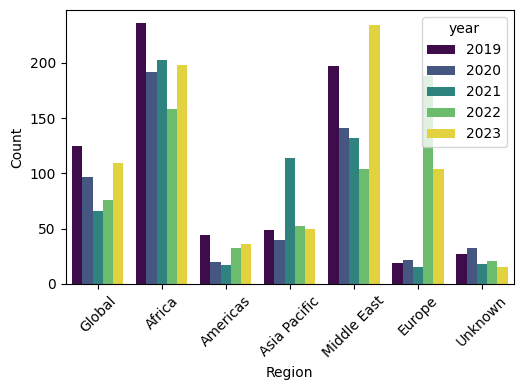

In [ ]:


plt.figure(figsize=[10,4])

#Region by year count
plt.subplot(1, 2, 1)
ax=sns.countplot(data=df_copy, x='region_clean', hue='year', palette='viridis')
plt.xlabel('Region')
plt.ylabel('Count')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Rotate the x-axis labels by 45 degrees for the first plot
plt.xticks(rotation=45)


# Display the plots
plt.tight_layout()
plt.show()


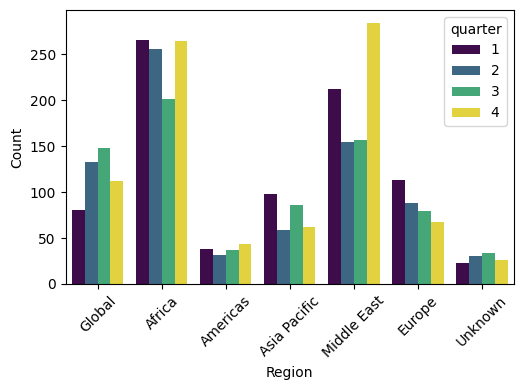

In [ ]:


plt.figure(figsize=[10, 4])

# Region by year count
plt.subplot(1, 2, 1)
ax=sns.countplot(data=df_copy, x='region_clean', hue='quarter', palette='viridis')
plt.xlabel('Region')
plt.ylabel('Count')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Rotate the x-axis labels by 45 degrees for the first plot
plt.xticks(rotation=45)

# Display the plots
plt.tight_layout()
plt.show()


**Year vs Sentiment**  

- Both models show a significant rise in negative sentiments in 2019 and 2023.  
- For the RoBERTa model, positive sentiment has been steadily declining over the years.  

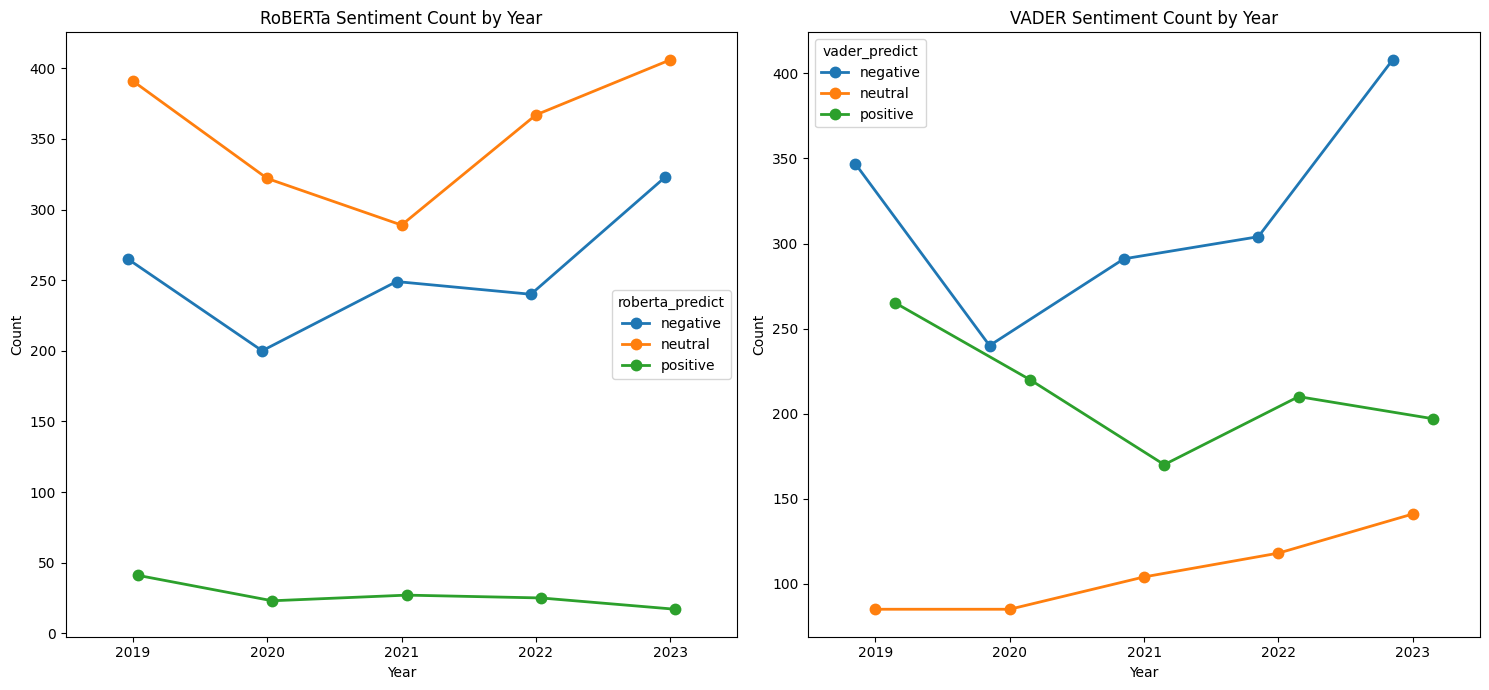

In [ ]:

# Create the count for 'roberta_predict' and 'year' combination
roberta_count = df_copy.groupby(['year', 'roberta_predict']).size().reset_index(name='count')

# Create the count for 'vader_predict' and 'year' combination
vader_count = df_copy.groupby(['year', 'vader_predict']).size().reset_index(name='count')

# Plotting the pointplots
plt.figure(figsize=[15, 7])

# Pointplot for 'roberta_predict'
plt.subplot(1, 2, 1)
ax=sns.pointplot(data=roberta_count, x='year', y='count', hue='roberta_predict',
              dodge=True, linestyles="-", markers='o', markersize=7, linewidth=2)
plt.title('RoBERTa Sentiment Count by Year')
plt.xlabel('Year')
plt.ylabel('Count')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Pointplot for 'vader_predict'
plt.subplot(1, 2, 2)
ax=sns.pointplot(data=vader_count, x='year', y='count', hue='vader_predict',
              dodge=0.3, linestyles="-", markers='o', markersize=7, linewidth=2)
plt.title('VADER Sentiment Count by Year')
plt.xlabel('Year')
plt.ylabel('Count')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

plt.tight_layout()
plt.show()


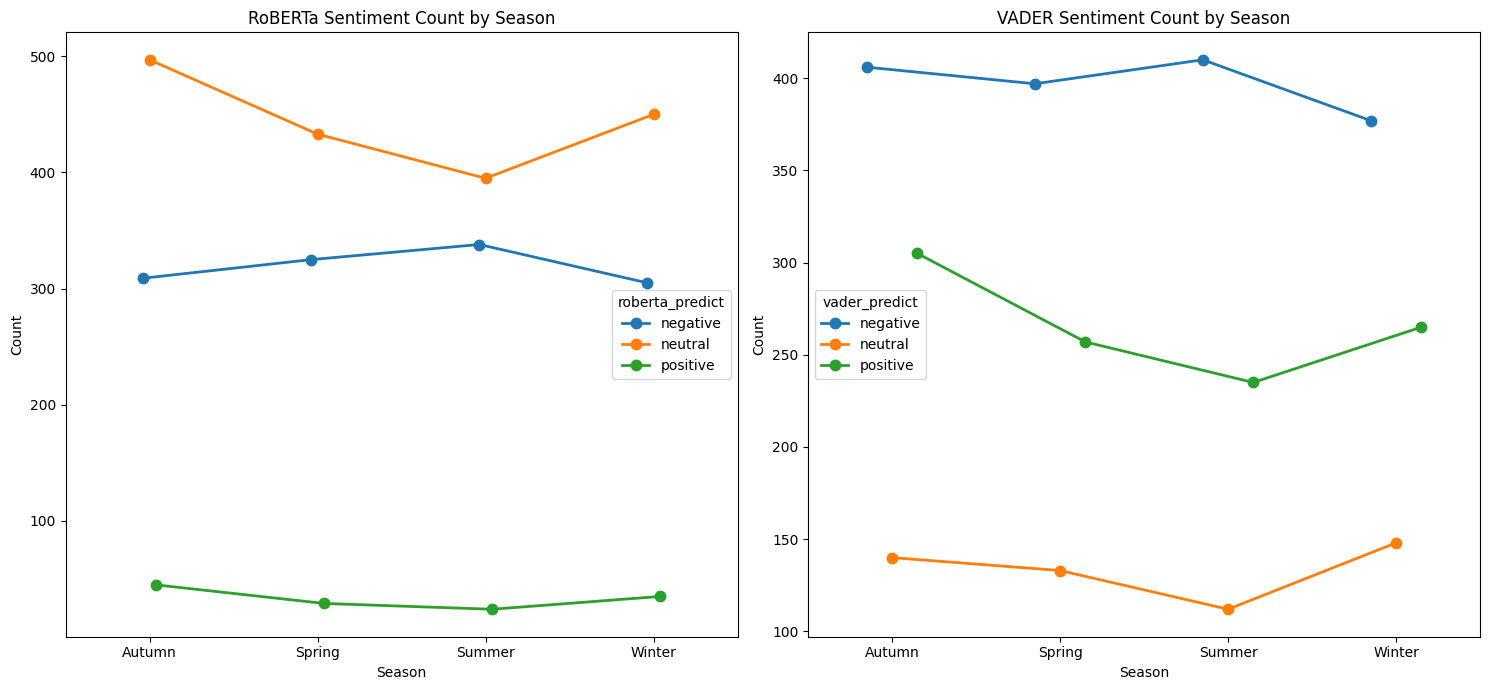

In [ ]:

# Create the count for 'roberta_predict' and 'year' combination
roberta_count = df_copy.groupby(['season', 'roberta_predict']).size().reset_index(name='count')

# Create the count for 'vader_predict' and 'year' combination
vader_count = df_copy.groupby(['season', 'vader_predict']).size().reset_index(name='count')

# Plotting the pointplots
plt.figure(figsize=[15, 7])

# Pointplot for 'roberta_predict'
plt.subplot(1, 2, 1)
ax=sns.pointplot(data=roberta_count, x='season', y='count', hue='roberta_predict',
              dodge=True, linestyles="-", markers='o', markersize=7, linewidth=2)
plt.title('RoBERTa Sentiment Count by Season')
plt.xlabel('Season')
plt.ylabel('Count')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

# Pointplot for 'vader_predict'
plt.subplot(1, 2, 2)
ax=sns.pointplot(data=vader_count, x='season', y='count', hue='vader_predict',
              dodge=0.3, linestyles="-", markers='o', markersize=7, linewidth=2)
plt.title('VADER Sentiment Count by Season')
plt.xlabel('Season')
plt.ylabel('Count')
# Set background color
#ax.set_facecolor('darkgray')  # Axes background color
#plt.gcf().set_facecolor('darkgray')  # Figure background color

plt.tight_layout()
plt.show()


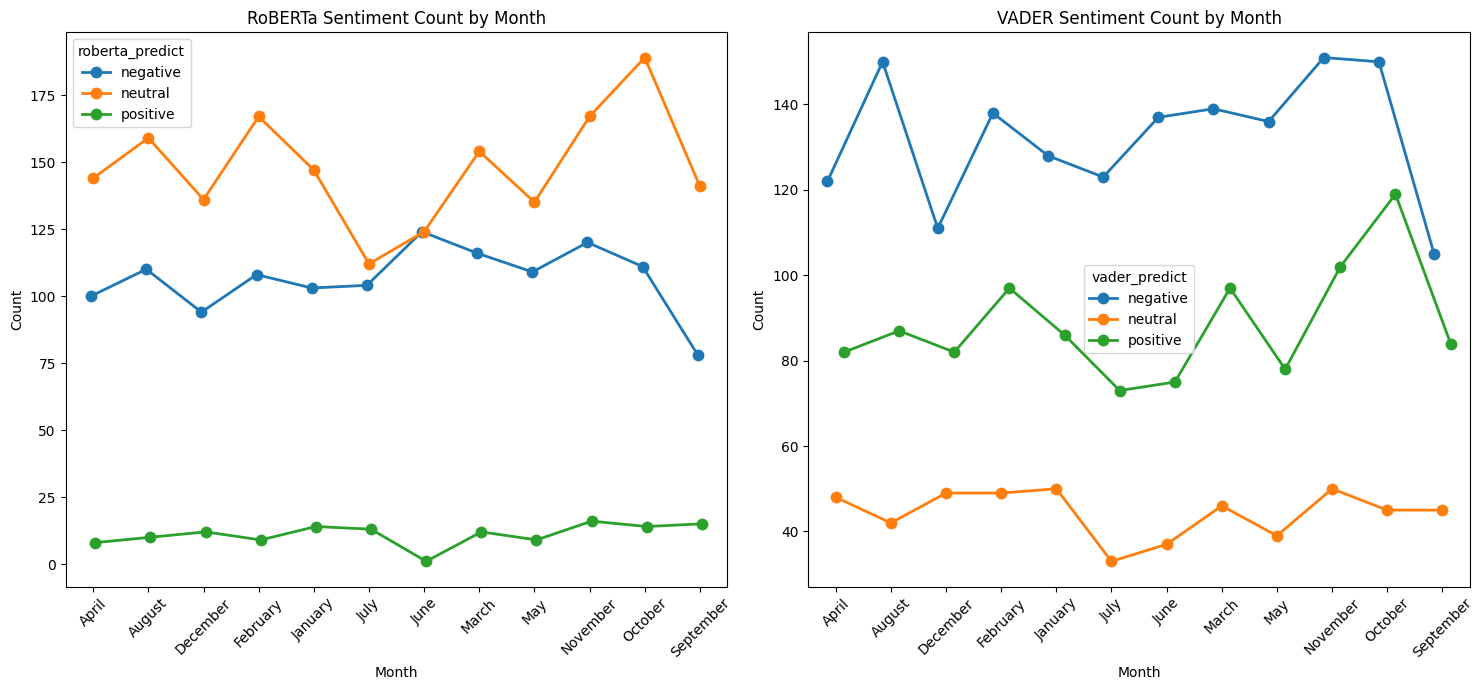

In [ ]:
# Create the count for 'roberta_predict' and 'month' combination
roberta_count = df_copy.groupby(['month', 'roberta_predict'], observed=False).size().reset_index(name='count')

# Create the count for 'vader_predict' and 'month' combination
vader_count = df_copy.groupby(['month', 'vader_predict'], observed=False).size().reset_index(name='count')

# Plotting the pointplots
plt.figure(figsize=[15, 7])

# Pointplot for 'roberta_predict'
plt.subplot(1, 2, 1)
ax = sns.pointplot(data=roberta_count, x='month', y='count', hue='roberta_predict',
                  dodge=True, linestyles="-", markers='o', markersize=7, linewidth=2)
plt.title('RoBERTa Sentiment Count by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Pointplot for 'vader_predict'
plt.subplot(1, 2, 2)
ax = sns.pointplot(data=vader_count, x='month', y='count', hue='vader_predict',
                  dodge=0.3, linestyles="-", markers='o', markersize=7, linewidth=2)
plt.title('VADER Sentiment Count by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Multivariate

Exploration of several variables

**Region vs Year vs Sentiment**  

Certain regions exhibit notable sentiment spikes in specific years:  
- **Middle East**: Peaks in 2019 and 2023.  
- **Europe**: A significant spike in 2022.  
- **Asia-Pacific**: A distinct rise in 2021.  
- **Americas**: Prominent spikes in 2019 and 2023.  

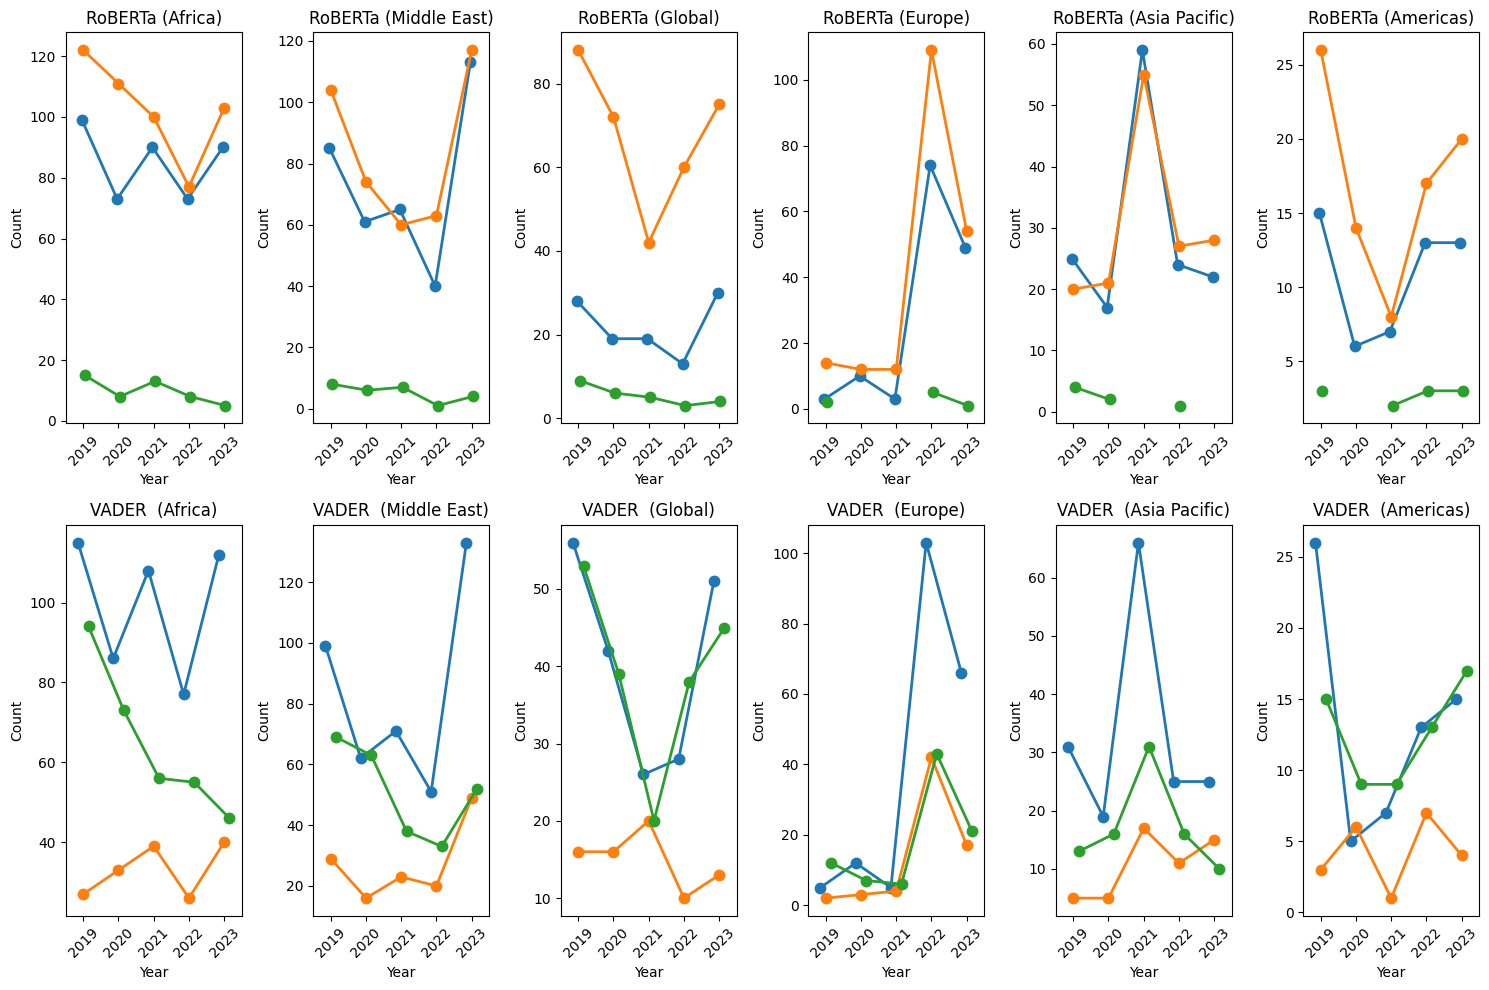

In [ ]:

# Define the regions
regions_of_interest = ['Africa', 'Middle East', 'Global', 'Europe', 'Asia Pacific', 'Americas']

# Set the figure size
plt.figure(figsize=[15, 10])

# Loop through the regions and plot the pointplots for each
for i, region in enumerate(regions_of_interest):
    region_df = df_copy[df_copy['region_clean'] == region]

    # Create the count for 'roberta_predict' and 'year' combination
    roberta_count = region_df.groupby(['year', 'roberta_predict']).size().reset_index(name='count')

    # Create the count for 'vader_predict' and 'year' combination
    vader_count = region_df.groupby(['year', 'vader_predict']).size().reset_index(name='count')

    # Pointplot for 'roberta_predict' (left subplot)
    plt.subplot(2, len(regions_of_interest), i+1)
    ax=sns.pointplot(data=roberta_count, x='year', y='count', hue='roberta_predict',
                  dodge=True, linestyles="-", markers='o', markersize=7, linewidth=2, legend=False)
    plt.title(f'RoBERTa ({region})')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate the x-axis labels
    # Set background color
    #ax.set_facecolor('darkgray')  # Axes background color
    #plt.gcf().set_facecolor('darkgray')  # Figure background color

    # Pointplot for 'vader_predict' (right subplot)
    plt.subplot(2, len(regions_of_interest), i+1+len(regions_of_interest))
    ax=sns.pointplot(data=vader_count, x='year', y='count', hue='vader_predict',
                  dodge=0.3, linestyles="-", markers='o', markersize=7, linewidth=2, legend=False)
    plt.title(f'VADER  ({region})')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate the x-axis labels
    # Set background color
    #ax.set_facecolor('darkgray')  # Axes background color
    #plt.gcf().set_facecolor('darkgray')  # Figure background color

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


### Summary of Exploration:

#### **Univariate Exploration:**
- **Geographic Coverage**: Most news on peace and security comes from **Africa** and the **Middle East**, with the **Americas** having the least coverage.
- **Sentiment Distribution**:
  - **RoBERTa**: 56% neutral, 40% negative, 4% positive.
  - **VADER**: 17% neutral, 50% negative, 33% positive.
- **Content Length**: Most content ranges between **5 to 15 words**.
- **Frequent Words**: Similar patterns in frequent words for both models, with differences in terms like **"war"**, **"crisis"**, and **"council"**.
- **Volume Trends**: News content declined in **2020** and **2021**.
- **Seasonality**: Most news appears in the **first and fourth quarters** of the year.

#### **Bivariate Exploration:**
- **Regional Sentiment**: **Africa** and the **Middle East** show the highest levels of **negative sentiment** across both models.
- **News Count Trends**:
  - Peaks in **2019 and 2023** for **Global**, **Africa**, and the **Middle East**.
  - Spikes in **2021** for **Asia-Pacific** and **2022** for **Europe**.
- **Sentiment Over Time**:
  - Significant rise in **negative sentiment** in **2019** and **2023**.
  - **RoBERTa** shows a steady decline in **positive sentiment** over time.

#### **Multivariate Exploration:**
- **Regional Sentiment Spikes**:
  - **Middle East**: Peaks in **2019** and **2023**.
  - **Europe**: Spike in **2022**.
  - **Asia-Pacific**: Rise in **2021**.
  - **Americas**: Peaks in **2019** and **2023**.  

This concise summary captures the essential trends in regional coverage, sentiment distributions, and temporal patterns in peace and security news.

# Conflicts Analysis  

This phase focuses on analyzing negative sentiment trends across specific years. A deeper investigation into these regions and periods will provide insights into the conflicts associated with them.  

### Key Steps:  
1. **Identify Top Keywords**: Extract the most frequent words from news articles tagged with negative sentiment for the specified years and regions.  
2. **Content Review**: Examine selected news articles from these periods to understand the context and drivers of conflict.  

This analysis will shed light on the underlying issues contributing to negative sentiment in these regions during these years.

**Middle East Analysis**

- **2019**: News coverage focused on ongoing violence and security issues, particularly in **Syria** and **Yemen**, with frequent mentions of *violence*, *attack*, *security*, and related terms.  
- **2023**: Reports were largely centered around the **Gaza** conflict and the **Israel-Palestine** situation, with key themes such as *crisis*, *aid*, *council*, and other humanitarian concerns emerging.

We will now delve deeper into the specific headlines from these periods to gain a clearer understanding of the context and dynamics surrounding these conflicts.

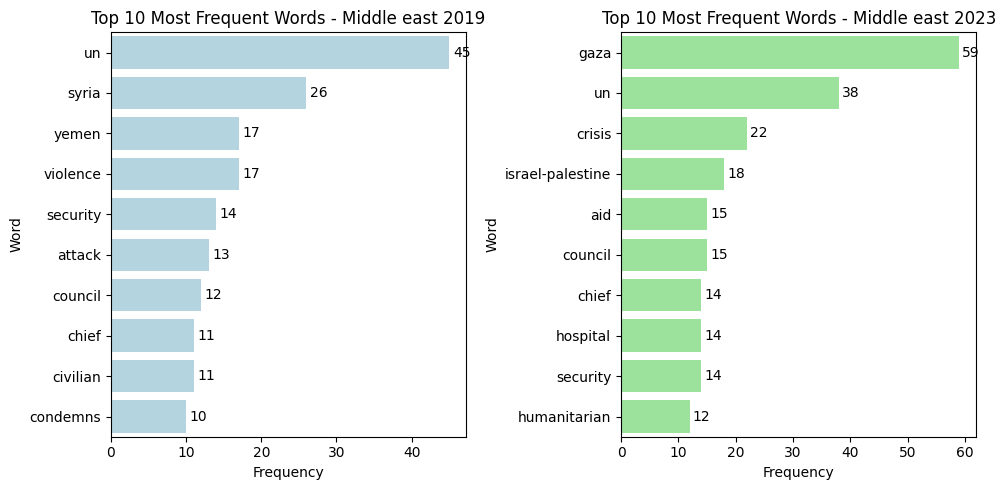

In [ ]:
roberta_middle_east_19=roberta_negative[(roberta_negative['region_clean'] == 'Middle East') & (roberta_negative['year'] == 2019)]
roberta_middle_east_23=roberta_negative[(roberta_negative['region_clean'] == 'Middle East') & (roberta_negative['year'] == 2023)]

'''
# Function to calculate word frequencies
def get_top_words(data, column, top_n=10):
    all_words = [word for content in data[column] for word in content]
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)
'''
# Get the top 10 words for 2019 and 2023
top_10_2019 = get_top_words(roberta_middle_east_19, 'content_clean', top_n=10)
top_10_2023 = get_top_words(roberta_middle_east_23, 'content_clean', top_n=10)

# Create DataFrames for easier plotting
top_10_2019_df = pd.DataFrame(top_10_2019, columns=['Word', 'Frequency'])
top_10_2023_df = pd.DataFrame(top_10_2023, columns=['Word', 'Frequency'])

# Create subplots to display the charts side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 2019  word frequencies
ax_2019 = sns.barplot(x='Frequency', y='Word', data=top_10_2019_df, ax=axes[0], color='lightblue')
axes[0].set_title('Top 10 Most Frequent Words - Middle east 2019')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Word')

# Annotate bars with counts for 2019
for index, row in top_10_2019_df.iterrows():
    axes[0].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Plot 2023  word frequencies
ax_2023 = sns.barplot(x='Frequency', y='Word', data=top_10_2023_df, ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Most Frequent Words - Middle east 2023')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

# Annotate bars with counts for 2023
for index, row in top_10_2023_df.iterrows():
    axes[1].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Most negative headlines middle east 2019**

In [ ]:
conflict_2019_middle_east = df_copy[['title', 'content', 'roberta_neg', 'month', 'year']][(df_copy['title'].str.contains
 ('syria|yemen|violence|attack|civilian', case=False, na=False)) &
  (df_copy['year'] == 2019) & (df_copy['region_clean'] == 'Middle East') &
   (df_copy['roberta_predict'] == 'negative')]

conflict_2019_middle_east=conflict_2019_middle_east.sort_values(by='roberta_neg', ascending=False)


conflict_2019_middle_east=conflict_2019_middle_east[:5]

# Print each text and its respective scores
for i, row in conflict_2019_middle_east.iterrows():
    print("title:", row['title'], "\n")
    print("title:", row['title'], "\n")
    print("month:", row['month'], "\n")
    print("year:", row['year'], "\n")
    print("\n" + "-"*50 + "\n")


title: Yemen blast kills 14 children, leaves others fighting for their lives in Sana’a 

title: Yemen blast kills 14 children, leaves others fighting for their lives in Sana’a 

month: April 

year: 2019 


--------------------------------------------------

title: Missile strike kills at least 12 civilians, including children, in Syria’s Idlib: UN humanitarians 

title: Missile strike kills at least 12 civilians, including children, in Syria’s Idlib: UN humanitarians 

month: November 

year: 2019 


--------------------------------------------------

title: Yemen: 11 more ‘terrible, senseless’ civilian deaths reported, following attack in Sana’a - top UN official 

title: Yemen: 11 more ‘terrible, senseless’ civilian deaths reported, following attack in Sana’a - top UN official 

month: April 

year: 2019 


--------------------------------------------------

title: Syria: At least seven children killed in yet another airstrike 

title: Syria: At least seven children killed in yet an

**Most negative headlines middle east 2023**

In [ ]:
conflict_2023_middle_east = df_copy[['title', 'content', 'roberta_neg', 'month', 'year']][(df_copy['title'].str.contains
 ('israel-palestine|gaza|crisis|aid|hospital', case=False, na=False)) &
  (df_copy['year'] == 2023) & (df_copy['region_clean'] == 'Middle East') &
   (df_copy['roberta_predict'] == 'negative')]

conflict_2023_middle_east=conflict_2023_middle_east.sort_values(by='roberta_neg', ascending=False)


conflict_2023_middle_east=conflict_2023_middle_east[:5]

# Print each text and its respective scores
for i, row in conflict_2023_middle_east.iterrows():
    print("title:", row['title'], "\n")
    print("title:", row['title'], "\n")
    print("month:", row['month'], "\n")
    print("year:", row['year'], "\n")
    print("\n" + "-"*50 + "\n")


title: Children sleep in streets, too afraid to go home after quake disaster 

title: Children sleep in streets, too afraid to go home after quake disaster 

month: February 

year: 2023 


--------------------------------------------------

title: Gaza City: Babies dying in hospital amid scenes of devastation 

title: Gaza City: Babies dying in hospital amid scenes of devastation 

month: November 

year: 2023 


--------------------------------------------------

title: Gaza: Testimonies highlight grim plight of civilians expecting to die 

title: Gaza: Testimonies highlight grim plight of civilians expecting to die 

month: October 

year: 2023 


--------------------------------------------------

title: Shock and terror in Gaza as bombardment of shattered enclave resumes 

title: Shock and terror in Gaza as bombardment of shattered enclave resumes 

month: December 

year: 2023 


--------------------------------------------------

title: Humanitarian crisis in Gaza could get far 

**Europe Analysis**

- **2022**: The majority of the news centered on the **Ukraine-Russia conflict**, with prominent discussions surrounding *war*, *nuclear*, *attack*, and related themes.  

We will further explore some of the key headlines from this period to understand the specifics of the coverage and the broader geopolitical context.

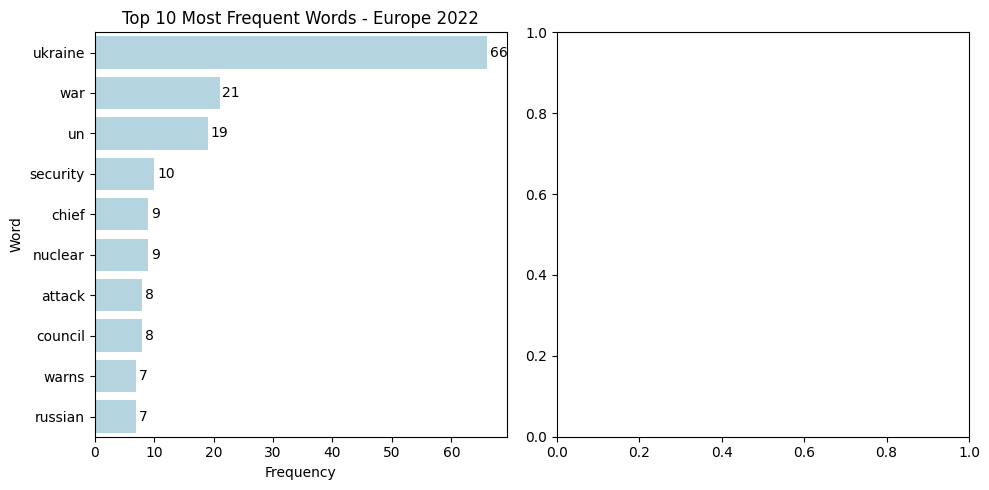

In [ ]:
roberta_europe=roberta_negative[(roberta_negative['region_clean'] == 'Europe') & (roberta_negative['year'] == 2022)]

'''
# Function to calculate word frequencies
def get_top_words(data, column, top_n=10):
    all_words = [word for content in data[column] for word in content]
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)
'''
# Get the top 10 words for 2019 and 2023
top_10_europe_2022 = get_top_words(roberta_europe, 'content_clean', top_n=10)
#top_10_2023 = get_top_words(roberta_middle_east_23, 'content_clean', top_n=10)

# Create DataFrames for easier plotting
top_10_europe_2022_df = pd.DataFrame(top_10_europe_2022, columns=['Word', 'Frequency'])
#top_10_2023_df = pd.DataFrame(top_10_2023, columns=['Word', 'Frequency'])

# Create subplots to display the charts side by side
fig, axes = plt.subplots(1,2, figsize=(10, 5))

# Plot 2019  word frequencies
ax_2022 = sns.barplot(x='Frequency', y='Word', data=top_10_europe_2022_df, ax=axes[0], color='lightblue')
axes[0].set_title('Top 10 Most Frequent Words - Europe 2022')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Word')

# Annotate bars with counts for 2019
for index, row in top_10_europe_2022_df.iterrows():
    axes[0].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)
'''
# Plot 2023  word frequencies
ax_2023 = sns.barplot(x='Frequency', y='Word', data=top_10_2023_df, ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Most Frequent Words - Middle east 2023')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

# Annotate bars with counts for 2023
for index, row in top_10_2023_df.iterrows():
    axes[1].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)
'''
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

 **Most negative headlines europe 2022**

In [ ]:
conflict_2022_europe = df_copy[['title', 'content', 'roberta_neg', 'month', 'year']][(df_copy['title'].str.contains
 ('ukraine|war|russia|nuclear|attack', case=False, na=False)) &
  (df_copy['year'] == 2022) & (df_copy['region_clean'] == 'Europe') &
   (df_copy['roberta_predict'] == 'negative')]

conflict_2022_europe=conflict_2022_europe.sort_values(by='roberta_neg', ascending=False)


conflict_2022_europe=conflict_2022_europe[:5]

# Print each text and its respective scores
for i, row in conflict_2022_europe.iterrows():
    print("title:", row['title'], "\n")
    print("title:", row['title'], "\n")
    print("month:", row['month'], "\n")
    print("year:", row['year'], "\n")
    print("\n" + "-"*50 + "\n")


title: Violence, rhetoric, hate speech, drive atrocity crimes in Ukraine and beyond, Security Council hears 

title: Violence, rhetoric, hate speech, drive atrocity crimes in Ukraine and beyond, Security Council hears 

month: June 

year: 2022 


--------------------------------------------------

title: Ukraine: Oxygen shortage putting lives in danger 

title: Ukraine: Oxygen shortage putting lives in danger 

month: March 

year: 2022 


--------------------------------------------------

title: Ukraine: Dozens dead and injured as UN condemns ‘utterly deplorable’ shopping centre attack 

title: Ukraine: Dozens dead and injured as UN condemns ‘utterly deplorable’ shopping centre attack 

month: June 

year: 2022 


--------------------------------------------------

title: More than 2 attacks a day on Ukraine health facilities; 6.5 million now internally displaced 

title: More than 2 attacks a day on Ukraine health facilities; 6.5 million now internally displaced 

month: March 

ye

**Asia-Pacific Analysis**

- **2022**: The spike in news coverage for **Asia-Pacific** in 2022 was largely driven by ongoing conflicts in **Myanmar** and **Afghanistan**, with frequent references to *violence*, *attack*, *rights*, *condemnations*, and related topics.

We will now dig deeper into the headlines from this period to better understand the narratives and underlying issues in these regions.

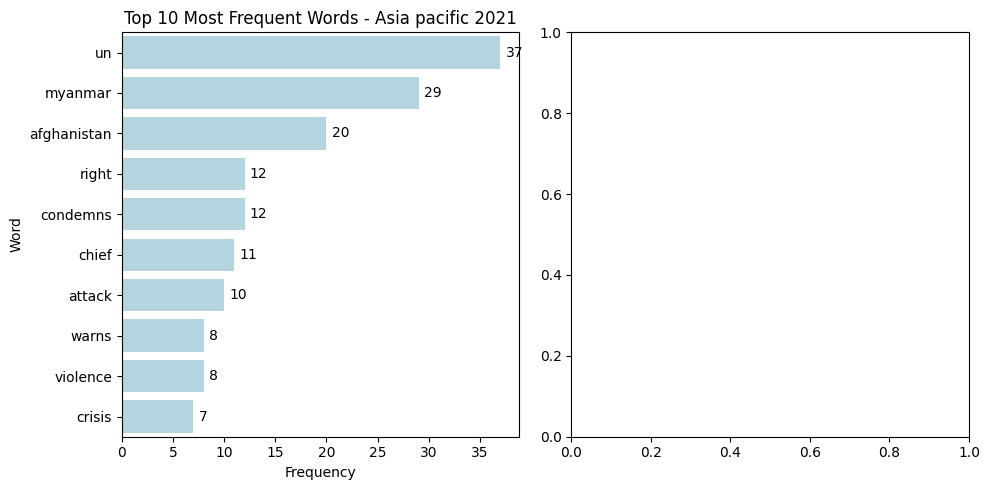

In [ ]:
roberta_asia_pacific=roberta_negative[(roberta_negative['region_clean'] == 'Asia Pacific') & (roberta_negative['year'] == 2021)]

'''
# Function to calculate word frequencies
def get_top_words(data, column, top_n=10):
    all_words = [word for content in data[column] for word in content]
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)
'''
# Get the top 10 words for 2019 and 2023
top_10_asia_pacific_2021 = get_top_words(roberta_asia_pacific, 'content_clean', top_n=10)
#top_10_2023 = get_top_words(roberta_middle_east_23, 'content_clean', top_n=10)

# Create DataFrames for easier plotting
top_10_asia_pacific_2021_df = pd.DataFrame(top_10_asia_pacific_2021, columns=['Word', 'Frequency'])
#top_10_2023_df = pd.DataFrame(top_10_2023, columns=['Word', 'Frequency'])

# Create subplots to display the charts side by side
fig, axes = plt.subplots(1,2, figsize=(10, 5))

# Plot 2019  word frequencies
ax_2021 = sns.barplot(x='Frequency', y='Word', data=top_10_asia_pacific_2021_df, ax=axes[0], color='lightblue')
axes[0].set_title('Top 10 Most Frequent Words - Asia pacific 2021')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Word')

# Annotate bars with counts for 2019
for index, row in top_10_asia_pacific_2021_df.iterrows():
    axes[0].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)
'''
# Plot 2023  word frequencies
ax_2023 = sns.barplot(x='Frequency', y='Word', data=top_10_2023_df, ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Most Frequent Words - Middle east 2023')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

# Annotate bars with counts for 2023
for index, row in top_10_2023_df.iterrows():
    axes[1].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)
'''
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

 **Most negative headlines europe 2021**

In [ ]:
conflict_2021_asia_pacific = df_copy[['title', 'content', 'roberta_neg', 'year', 'month']][(df_copy['title'].str.contains
 ('myanmar|violence|attack|crisis|attack', case=False, na=False)) &
  (df_copy['year'] == 2021) & (df_copy['region_clean'] == 'Asia Pacific') &
   (df_copy['roberta_predict'] == 'negative')]

conflict_2021_asia_pacific=conflict_2021_asia_pacific.sort_values(by='roberta_neg', ascending=False)


conflict_2021_asia_pacific=conflict_2021_asia_pacific[:5]

# Print each text and its respective scores
for i, row in conflict_2021_asia_pacific.iterrows():
    print("title:", row['title'], "\n")
    print("title:", row['title'], "\n")
    print("month:", row['month'], "\n")
    print("year:", row['year'], "\n")
    print("\n" + "-"*50 + "\n")

title: Yemen: Endless suffering of children continues due to war, aid crisis 

title: Yemen: Endless suffering of children continues due to war, aid crisis 

month: September 

year: 2021 


--------------------------------------------------

title: ‘Unacceptable’ violence, intimidation and harassment in Myanmar – UN chief 

title: ‘Unacceptable’ violence, intimidation and harassment in Myanmar – UN chief 

month: February 

year: 2021 


--------------------------------------------------

title: UN condemns 'despicable' suicide attack at mosque in southern Afghanistan 

title: UN condemns 'despicable' suicide attack at mosque in southern Afghanistan 

month: October 

year: 2021 


--------------------------------------------------

title: Myanmar crisis: UN chief 'appalled' by escalating violence with dozens reported killed over weekend 

title: Myanmar crisis: UN chief 'appalled' by escalating violence with dozens reported killed over weekend 

month: March 

year: 2021 


---------

**Americas Analysis**

- **2019**: News coverage focused on **Venezuela** and **Colombia**, with key topics including *rights*, *killed*, *crisis*, and related issues.  
- **2022 and 2023**: Reporting shifted towards **Haiti**, highlighting *violence*, *gangs*, *UNICEF*, and *crisis*, reflecting ongoing humanitarian concerns.

We will now explore specific headlines from these years to gain deeper insights into the events and underlying causes driving these narratives.

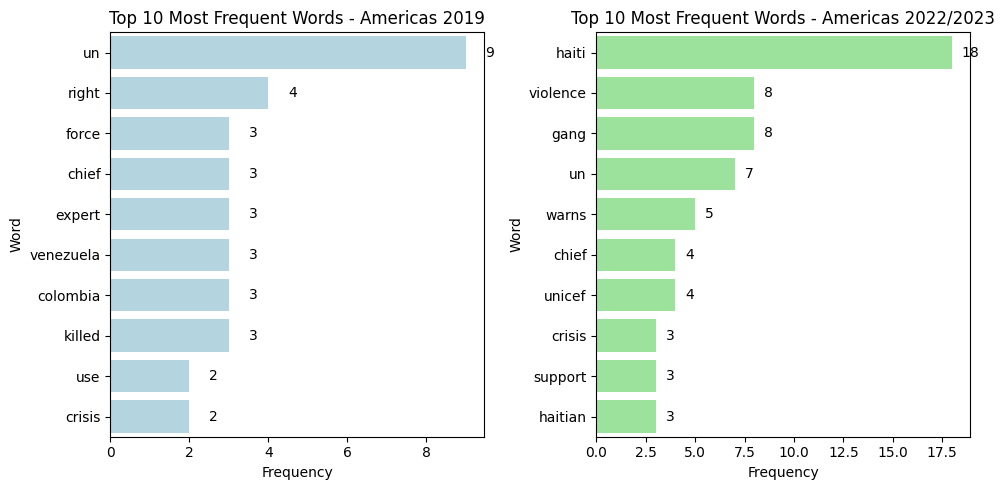

In [ ]:
roberta_americas_19=roberta_negative[(roberta_negative['region_clean'] == 'Americas') & (roberta_negative['year'] == 2019)]
roberta_americas_2223=roberta_negative[(roberta_negative['region_clean'] == 'Americas') & (roberta_negative['year'].isin([2022, 2023]))]

'''
# Function to calculate word frequencies
def get_top_words(data, column, top_n=10):
    all_words = [word for content in data[column] for word in content]
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)
'''
# Get the top 10 words for 2019 and 2023
top_10_americas_2019 = get_top_words(roberta_americas_19, 'content_clean', top_n=10)
top_10_americas_2223 = get_top_words(roberta_americas_2223, 'content_clean', top_n=10)

# Create DataFrames for easier plotting
top_10_americas_2019_df = pd.DataFrame(top_10_americas_2019, columns=['Word', 'Frequency'])
top_10_americas_2223_df = pd.DataFrame(top_10_americas_2223, columns=['Word', 'Frequency'])

# Create subplots to display the charts side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 2019  word frequencies
ax_2019 = sns.barplot(x='Frequency', y='Word', data=top_10_americas_2019_df, ax=axes[0], color='lightblue')
axes[0].set_title('Top 10 Most Frequent Words - Americas 2019')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Word')

# Annotate bars with counts for 2019
for index, row in top_10_americas_2019_df.iterrows():
    axes[0].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Plot 2023  word frequencies
ax_2023 = sns.barplot(x='Frequency', y='Word', data=top_10_americas_2223_df, ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Most Frequent Words - Americas 2022/2023')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

# Annotate bars with counts for 2023
for index, row in top_10_americas_2223_df.iterrows():
    axes[1].text(row['Frequency'] + 0.5, index, str(row['Frequency']), va='center', ha='left', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

 **Most negative headlines Americas 2019**

In [ ]:
conflict_2019_americas = df_copy[['title', 'content', 'roberta_neg', 'month', 'year']][(df_copy['title'].str.contains
 ('venezuala|colombia|crisis|force|right', case=False, na=False)) &
  (df_copy['year'] == 2019) & (df_copy['region_clean'] == 'Americas') &
   (df_copy['roberta_predict'] == 'negative')]

conflict_2019_americas=conflict_2019_americas.sort_values(by='roberta_neg', ascending=False)


conflict_2019_americas=conflict_2019_americas[:5]

# Print each text and its respective scores
for i, row in conflict_2019_americas.iterrows():
    print("title:", row['title'], "\n")
    print("title:", row['title'], "\n")
    print("month:", row['month'], "\n")
    print("year:", row['year'], "\n")
    print("\n" + "-"*50 + "\n")


title: Tensions escalate in Venezuela, civilians killed and injured: top UN officials lament excessive use of force by authorities 

title: Tensions escalate in Venezuela, civilians killed and injured: top UN officials lament excessive use of force by authorities 

month: February 

year: 2019 


--------------------------------------------------

title: Repression, use of force risk worsening Bolivia crisis: UN human rights chief 

title: Repression, use of force risk worsening Bolivia crisis: UN human rights chief 

month: November 

year: 2019 


--------------------------------------------------

title: Colombia: ‘Terrible trend’ of rights defenders killed, harassed; UN calls for ‘significant effort’ to tackle impunity 

title: Colombia: ‘Terrible trend’ of rights defenders killed, harassed; UN calls for ‘significant effort’ to tackle impunity 

month: May 

year: 2019 


--------------------------------------------------

title: Violence can ‘never be the answer’: UN rights expert

 **Most negative headlines Americas 2019**

In [ ]:
conflict_22_23_americas = df_copy[['title', 'content', 'roberta_neg', 'month', 'year']][(df_copy['title'].str.contains
 ('haiti|violence|gang|crisis|warns', case=False, na=False)) &
  (df_copy['year'].isin([2022, 2023])) & (df_copy['region_clean'] == 'Americas') &
   (df_copy['roberta_predict'] == 'negative')]

conflict_22_23_americas=conflict_22_23_americas.sort_values(by='roberta_neg', ascending=False)


conflict_22_23_americas=conflict_22_23_americas[:5]

# Print each text and its respective scores
for i, row in conflict_22_23_americas.iterrows():
    print("title:", row['title'], "\n")
    print("month:", row['month'], "\n")
    print("year:", row['year'], "\n")
    print("\n" + "-"*50 + "\n")


title: Haiti: Children facing triple threat of insecurity, malnutrition, disease 

month: October 

year: 2023 


--------------------------------------------------

title: Haiti: Armed violence reaches ‘unimaginable and intolerable levels’ 

month: May 

year: 2022 


--------------------------------------------------

title: Police overwhelmed, development stalled, as gang violence spirals in Haiti 

month: January 

year: 2023 


--------------------------------------------------

title: ‘The world is failing the Haitian people’ warns UNICEF chief 

month: June 

year: 2023 


--------------------------------------------------

title: Haiti: Gang clashes in capital force hundreds to flee their homes 

month: May 

year: 2022 


--------------------------------------------------



### Key Points Summary: **Conflict Analysis**

#### **Middle East**:
- **2019**: Focused on **Syria** and **Yemen**, highlighting **violence**, **attack**, and **security** due to ongoing conflicts.  
- **2023**: Shifted to the **Gaza conflict** and **Israel-Palestine**, with themes like **crisis**, **aid**, and **humanitarian concerns**.

#### **Europe**:
- **2022**: Dominated by the **Ukraine-Russia conflict**, with discussions of **war**, **nuclear**, and **attack**, emphasizing the global impact and escalation.

#### **Asia-Pacific**:
- **2022**: Coverage driven by conflicts in **Myanmar** and **Afghanistan**, focusing on **violence**, **attack**, **rights**, and **condemnations**, reflecting human rights and political unrest.

#### **Americas**:
- **2019**: Centered on **Venezuela** and **Colombia**, with key topics like **rights**, **killed**, and **crisis**, highlighting political and humanitarian crises.  
- **2022 and 2023**: Shifted to **Haiti**, emphasizing **violence**, **gangs**, **UNICEF**, and **crisis**, underscoring instability and humanitarian issues.

This analysis highlights evolving conflict narratives and regional humanitarian concerns shaping global news coverage.

# Stage 2: Exploring Portuguese Media Trends

In this stage, we will analyze how the selected words, bigrams, and trigrams have been reflected in Portuguese media over the years, specifically on **publico.pt** and **jn.pt**.

### Key Steps:
1. **Word Selection**: Identify a list of significant words, bigrams, and trigrams that reflect the core themes of the conflicts analyzed (e.g., *violence*, *crisis*, *attack*, *rights*, *war*).
2. **Media Analysis**: Retrieve and analyze counts of selected word from **publico.pt** and **jn.pt** to track the frequency.

This analysis will help us understand how Portuguese-language media have covered these issues.

In [ ]:
drive.mount('/content/drive')
df1 =pd.read_csv('/content/drive/My Drive/Data mining Project/arquivo_with_urls_by_year.csv')
df2 =pd.read_csv('/content/drive/My Drive/Data mining Project/portuguese_with_urls_by_year.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Acquisition: Exploring Portuguese Media Through Arquivo.pt

To gather relevant data for this stage , we will start by accessing **Arquivo.pt**, a digital archive of Portuguese web content. This will allow us to retrieve the count of the words, bigrams, and trigrams from Portuguese websites, specifically **publico.pt** and **jn.pt**.

### Key Steps:
1. **Search on Arquivo.pt**: Use keywords and phrases related to the selected words, bi-grams, and n-grams (e.g., *violência*, *crise*, *direitos*, *guerra*, *direitos humanos*, etc.) to locate these words from **publico.pt** and **jn.pt**.
2. **Filter by Date**: Specify the date ranges for the years and regions we want to analyze (e.g., 2019, 2022, 2023).
3. **Count the frequency of these words**: count the frequency of these words from these website and download them

This will form the basis of our analysis, helping us track how the Portuguese media has reported on key topics over the years and how they align with global conflict events.

In [ ]:
'''
def get_results_by_year(frequent_words, site):
    results = []
    search_urls = []  # List to store the URLs for each search
    for i in range(2019, 2024):
        data = [int(f"{i}0101"), int(f"{i}1231")]
        site_url = f"https://arquivo.pt/textsearch?q={frequent_words}&prettyPrint=false&from={data[0]}&to={data[1]}&siteSearch={site}"

        retries = 3
        for attempt in range(retries):
            try:
                # Request with a timeout
                response = requests.get(site_url, timeout=10)
                response.raise_for_status()  # Raise an exception for bad responses
                content = response.json()
                results.append(content['estimated_nr_results'])
                search_urls.append(site_url)  # Append the URL to the list
                print(f"{frequent_words} ({site}), {i}, ok", end=" | ")
                break  # Exit the retry loop on success
            except (requests.exceptions.Timeout, requests.exceptions.RequestException) as e:
                print(f"Attempt {attempt + 1} failed for {frequent_words} ({site}), {i}: {e}")
                if attempt == retries - 1:  # Last retry attempt
                    results.append(None)  # If all retries fail, append None
                    search_urls.append(site_url)  # Still append the URL
                    print(f"Failed to retrieve data for {frequent_words} ({site}), {i}")
                else:
                    time.sleep(5)  # Wait for 5 seconds before retrying

    return results, search_urls  # Return both results and URLs

# Define the different Portuguese media sites
sites = {
    "publico": 'www.publico.pt,publico.pt',
    'jn': 'www.jn.pt,jn.pt'
}

# List of frequent words
frequent_words = ['conselho de segurança', 'república democrática do congo', 'dr congo', 'congo', 'direitos humanos', 'república centro-africana', 'ataque', 'violência', 'condena ', 'Ucrânia', 'crise', 'guerra', 'Sudão do Sul']

# Create an empty list to collect the data
final_data = []

# Loop over each site and frequent word
for site_name, site_url in sites.items():
    for term in frequent_words:
        results, search_urls = get_results_by_year(term, site_url)  # Get both results and URLs
        for i, result in enumerate(results):
            # Append data in the format of year, frequent_word, site, count_of_frequent_word, and url
            final_data.append({
                'year': 2019 + i,  # Adjust year accordingly
                'frequent_word': term,
                'site': site_name,
                'count_of_frequent_word': result,  # This is the count of the frequent word
                'url': search_urls[i]  # The corresponding URL for the search
            })
        print(f"{term} ({site_name})\n")

# Convert the list of dictionaries into a DataFrame
df2 = pd.DataFrame(final_data)

# Save the DataFrame to a CSV file
df2.to_csv('results_by_site_and_year.csv', index=False)

print("Data saved to 'results_by_site_and_year.csv'")


In [ ]:
'''
import requests

# Step 2: Test broader keyword to check if specific keywords are causing the issue
test_url_broad_query = "https://arquivo.pt/textsearch?q=segurança&prettyPrint=false&from=20210101&to=20211231&siteSearch=www.publico.pt"
response_broad_query = requests.get(test_url_broad_query)

# Print the response to see if the broader query yields results
print("Response with broader query:")
print(response_broad_query.json())

# Step 1: Test if the archive has any data for the specific site in 2021 without `siteSearch`
test_url_no_site = "https://arquivo.pt/textsearch?q=conselho+de+segurança&prettyPrint=false&from=20210101&to=20211231"
response_no_site = requests.get(test_url_no_site)

# Print the response to check if results are found without the site filter
print("Response without siteSearch:")
print(response_no_site.json())




##### through arquivo

In [ ]:
'''
def get_results_by_year(frequent_words):
    results = []
    search_urls = []  # List to store the URLs for each search
    for i in range(2019, 2024):
        data = [int(f"{i}0101"), int(f"{i}1231")]
        site_url = f"https://arquivo.pt/textsearch?q={frequent_words}&prettyPrint=false&from={data[0]}&to={data[1]}"

        retries = 3
        for attempt in range(retries):
            try:
                # Request with a timeout
                response = requests.get(site_url, timeout=10)
                response.raise_for_status()  # Raise an exception for bad responses
                content = response.json()
                results.append(content['estimated_nr_results'])
                search_urls.append(site_url)  # Append the URL to the list
                print(f"{frequent_words}, {i}, ok", end=" | ")
                break  # Exit the retry loop on success
            except (requests.exceptions.Timeout, requests.exceptions.RequestException) as e:
                print(f"Attempt {attempt + 1} failed for {frequent_words}, {i}: {e}")
                if attempt == retries - 1:  # Last retry attempt
                    results.append(None)  # If all retries fail, append None
                    search_urls.append(site_url)  # Still append the URL
                    print(f"Failed to retrieve data for {frequent_words}, {i}")
                else:
                    time.sleep(5)  # Wait for 5 seconds before retrying

    return results, search_urls  # Return both results and URLs

# List of frequent words
frequent_words = ['conselho de segurança', 'república democrática do congo', 'dr congo', 'congo', 'direitos humanos', 'república centro-africana', 'ataque', 'violência', 'condena ', 'Ucrânia', 'crise', 'guerra', 'Sudão do Sul']

# Create an empty list to collect the data for the final DataFrame
final_data = []

# Loop over each frequent word and retrieve data for the years 2019-2023
for term in frequent_words:
    results, search_urls = get_results_by_year(term)  # Get both results and URLs
    for i, result in enumerate(results):
        # Append data in the format of year, frequent_word, count, and url
        final_data.append({
            'year': 2019 + i,  # Adjust year accordingly
            'frequent_word': term,
            'count_of_frequent_word': result,  # This is the count of the frequent word
            'url': search_urls[i]  # The corresponding URL for the search
        })
    print(f"{term} (all sites)\n")

# Convert the list of dictionaries into a DataFrame
final_df = pd.DataFrame(final_data)

# Save the DataFrame to a CSV file
#final_df.to_csv('results_with_urls_by_year.csv', index=False)

#print("Data saved to 'results_with_urls_by_year.csv'")


In [ ]:
'''

# Save the DataFrame to a CSV file
df2.to_csv('portuguese_with_urls_by_year.csv', index=False)

# Save the DataFrame to a CSV file
final_df.to_csv('arquivo_with_urls_by_year.csv', index=False)

from google.colab import files
files.download('portuguese_with_urls_by_year.csv')
files.download('arquivo_with_urls_by_year.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Stage 2 Cleaning

In [ ]:
# Group by 'frequent_word' and sum the 'count_of_frequent_word'
df2_year = df2.groupby('year', as_index=False)['count_of_frequent_word'].sum()


In [ ]:
df2['frequent_word'].unique()

array(['conselho de segurança', 'república democrática do congo',
       'dr congo', 'congo', 'direitos humanos',
       'república centro-africana', 'ataque', 'violência', 'condena ',
       'Ucrânia', 'crise', 'guerra', 'Sudão do Sul'], dtype=object)

**there are 3 congo related terms, lets summarize them as one**

In [ ]:
# Define the keywords to group
keywords = ['dr congo', 'congo', 'república democrática do congo']

# Filter rows where 'frequent_word' is in the list of keywords
df2['frequent_word'] = df2['frequent_word'].replace(keywords, 'congo-related terms')


In [ ]:
# Filter out rows where the 'year' 0 for count_of_frequent_word
df_filtered = df2[~df2['year'].isin([2021, 2022, 2023])]

In [ ]:
# Group by 'frequent_word' and sum the 'count_of_frequent_word'
df2_grouped = df_filtered.groupby('frequent_word', as_index=False)['count_of_frequent_word'].sum()


In [ ]:
# Group by 'frequent_word' and 'year', and sum the 'count_of_frequent_word'
df2_grouped_by_year = df_filtered.groupby(['frequent_word', 'year'], as_index=False)['count_of_frequent_word'].sum()

 ### Stage 2 Exploration

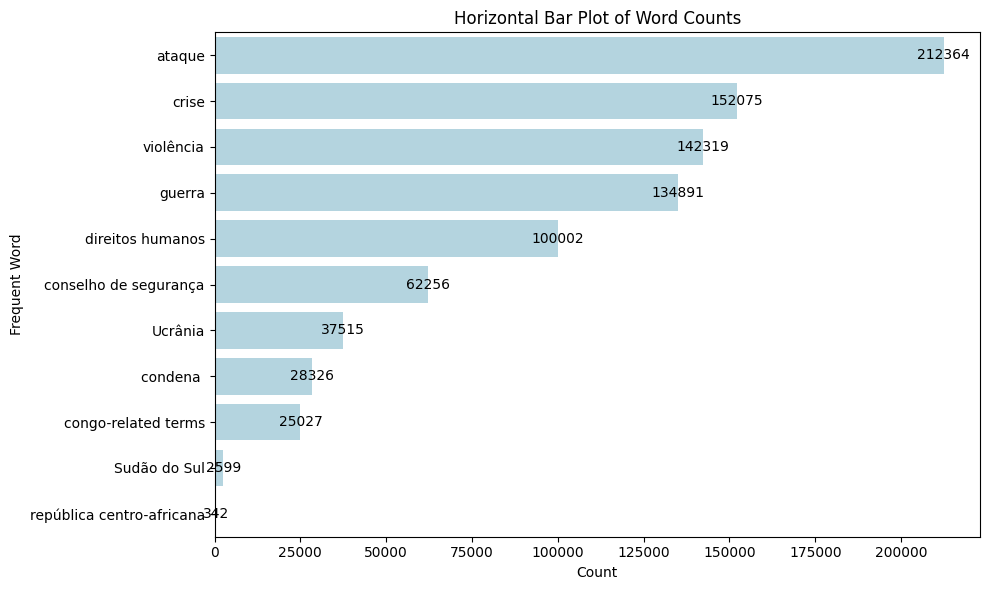

In [ ]:
# Sort the DataFrame by 'count_of_frequent_word' in descending order
df2_sorted = df2_grouped.sort_values(by='count_of_frequent_word', ascending=False)

# Horizontal Bar Plot
plt.figure(figsize=(10, 6))
ax= sns.barplot(x='count_of_frequent_word', y='frequent_word', data=df2_sorted, color='lightblue', errorbar=None)
# Set background color
#ax.set_facecolor('lightgray')  # Axes background color
#plt.gcf().set_facecolor('lightgray')  # Figure background color


# Add the value labels to each bar
for p in ax.patches:
    ax.text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2,
            f'{int(p.get_width())}', ha='center', va='center', color='black', fontsize=10)

# Customize the plot
plt.title('Horizontal Bar Plot of Word Counts')
plt.xlabel('Count')
plt.ylabel('Frequent Word')
plt.tight_layout()
plt.show()


**Word Counts in Portuguese Media**

Words such as "attack," "crisis," "violence," and "war" have become increasingly frequent in the selected years.

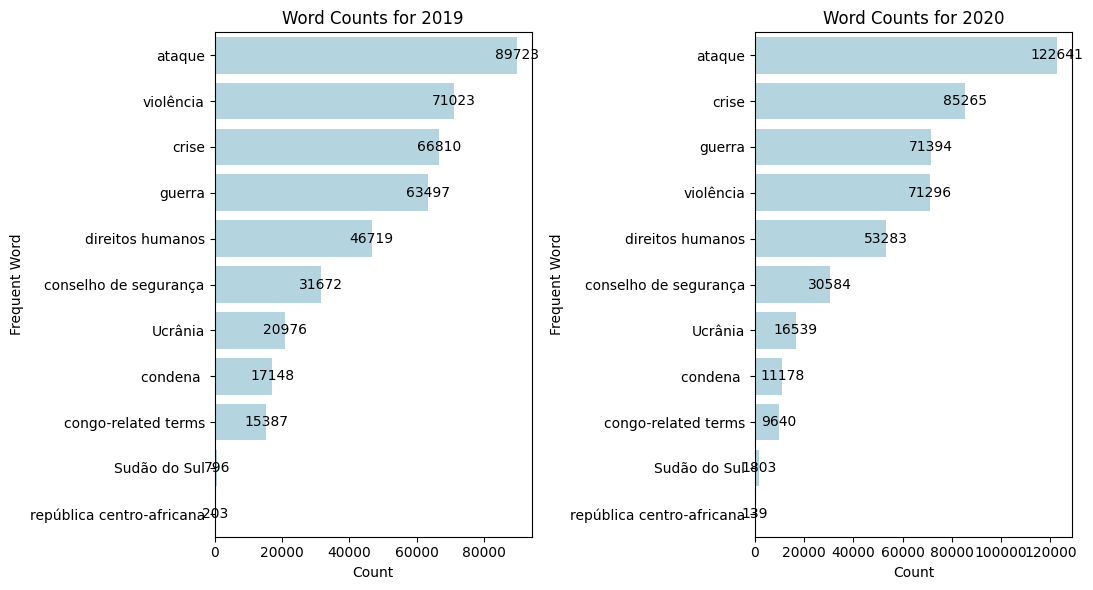

In [ ]:
# Sort the DataFrame by 'count_of_frequent_word' in descending order
df2_year_sorted = df2_grouped_by_year.sort_values(by='count_of_frequent_word', ascending=False)


# Filter the data for 2019 and 2020
df2_filtered = df2_year_sorted[df2_year_sorted['year'].isin([2019, 2020])]

# Create the side-by-side plots
plt.figure(figsize=(11,6))

# Plot for 2019
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot in the first slot
df2_2019 = df2_filtered[df2_filtered['year'] == 2019]
ax = sns.barplot(x='count_of_frequent_word', y='frequent_word', data=df2_2019, color='lightblue', errorbar=None)

# Add value labels for 2019
for p in ax.patches:
    ax.text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2,
            f'{int(p.get_width())}', ha='center', va='center', color='black', fontsize=10)

    # Set background color
#    ax.set_facecolor('lightgray')  # Axes background color
#    plt.gcf().set_facecolor('lightgray')  # Figure background color

plt.title('Word Counts for 2019')
plt.xlabel('Count')
plt.ylabel('Frequent Word')

# Plot for 2020
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot in the second slot
df2_2020 = df2_filtered[df2_filtered['year'] == 2020]
ax = sns.barplot(x='count_of_frequent_word', y='frequent_word', data=df2_2020, color='lightblue', errorbar=None)

# Add value labels for 2020
for p in ax.patches:
    ax.text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2,
            f'{int(p.get_width())}', ha='center', va='center', color='black', fontsize=10)
    # Set background color
#    ax.set_facecolor('lightgray')  # Axes background color
#    plt.gcf().set_facecolor('lightgray')  # Figure background color

plt.title('Word Counts for 2020')
plt.xlabel('Count')
plt.ylabel('Frequent Word')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


### Público vs JN

Let's analyze these two prominent Portuguese media outlets—**Público** and **JN (Jornal de Notícias)**—individually. We will also examine how the frequency of key terms on these websites, such as "attack," "crisis," "violence," and "war," correlates with topics related to **UN peace and security**. This will help us understand the media landscape in Portugal and how these outlets engage with global peace and security issues.

In [ ]:
# Group by 'frequent_word', 'year', and 'site', and sum the 'count_of_frequent_word'
df2_grouped_by_site = df_filtered.groupby(['frequent_word', 'year', 'site'], as_index=False)['count_of_frequent_word'].sum()


**Word Frequency**

The distribution of these words (such as "attack," "crisis," "violence," and "war") is quite similar across Portuguese media outlets. Both **Público** and **JN** show comparable patterns in the frequency of these terms, indicating a shared focus on these critical issues in their coverage.

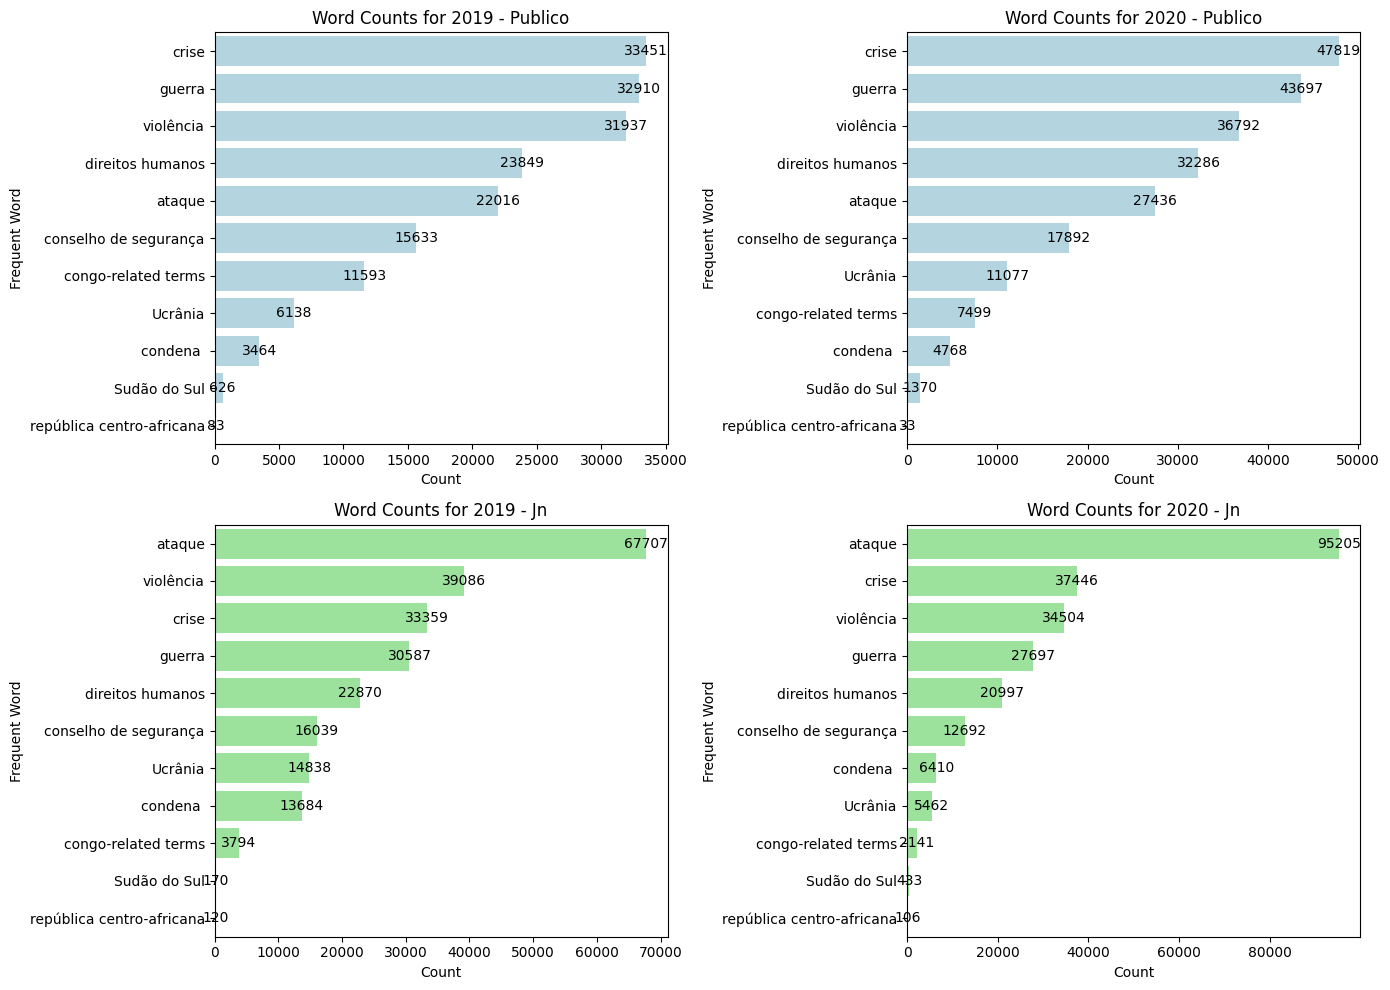

In [ ]:
# Sort the DataFrame by 'count_of_frequent_word' in descending order
df2_site_sorted = df2_grouped_by_site.sort_values(by='count_of_frequent_word', ascending=False)

# Filter the data for 2019 and 2020
df2_filtered = df2_site_sorted[df2_site_sorted['year'].isin([2019, 2020])]

# Define the sites for plotting
sites = ['publico', 'jn']

# Create the side-by-side plots with two rows
plt.figure(figsize=(14, 10))

# Loop through each site and plot
for i, site in enumerate(sites, start=1):
    # Set color based on site
    color = 'lightblue' if site == 'publico' else 'lightgreen'

    # Plot for each site and year
    for year_index, year in enumerate([2019, 2020], start=1):
        # Determine subplot position based on site and year
        row = i - 1  # 0 for first row, 1 for second row
        col = year_index - 1  # 0 for 2019, 1 for 2020

        # Create subplot for the specific year and site
        plt.subplot(2, 2, row * 2 + col + 1)

        # Filter the data for the specific site and year
        df2_site = df2_filtered[df2_filtered['site'] == site]
        df2_year = df2_site[df2_site['year'] == year]

        # Plot the barplot with site-specific color
        ax = sns.barplot(x='count_of_frequent_word', y='frequent_word', data=df2_year, color=color, errorbar=None)

        # Add value labels for the bars
        for p in ax.patches:
            ax.text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2,
                    f'{int(p.get_width())}', ha='center', va='center', color='black', fontsize=10)

        # Set titles and labels
        plt.title(f'Word Counts for {year} - {site.capitalize()}')
        plt.xlabel('Count')
        plt.ylabel('Frequent Word')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
# Group by 'frequent_word' and 'year', and sum the 'count_of_frequent_word'
df2_site= df_filtered.groupby(['site', 'frequent_word'], as_index=False)['count_of_frequent_word'].sum()



In [ ]:


# Create a DataFrame
data = {
    'key_term': ['South Sudan', 'Ukraine', 'Attack', 'Condemn', 'Congo', 'Security council', 'Crisis', 'Human rights', 'War', 'Central African Republic', 'Violence' ],
    'un': [37, 137, 215, 139, 73, 112, 152, 51, 142, 22, 188],
    'publico' : df2_site[df2_site['site']=='publico']['count_of_frequent_word'].to_list(),
    'jn': df2_site[df2_site['site']=='jn']['count_of_frequent_word'].to_list()
}

# Create the DataFrame
df_terms = pd.DataFrame(data)

# Display the sample DataFrame
#display(df_terms)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create the MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to 'un', 'publico', and 'jn'
df_terms[['un_scaled', 'publico_scaled', 'jn_scaled']] = scaler.fit_transform(df_terms[['un', 'publico', 'jn']])

# Display the scaled DataFrame
#display(df_terms[['key_term', 'un_scaled', 'publico_scaled', 'jn_scaled']])

**Association of Word Frequency with UN Peace and Security Topics**

The content from **JN (Jornal de Notícias)** shows the highest correlation with **UN peace and security topics**, with a correlation coefficient of **0.8**. In comparison, **Público** has a lower correlation of **0.57** with the same topics. This suggests that JN's coverage aligns more closely with the themes of peace and security as discussed by the UN, while Público's content shows a more moderate correlation.

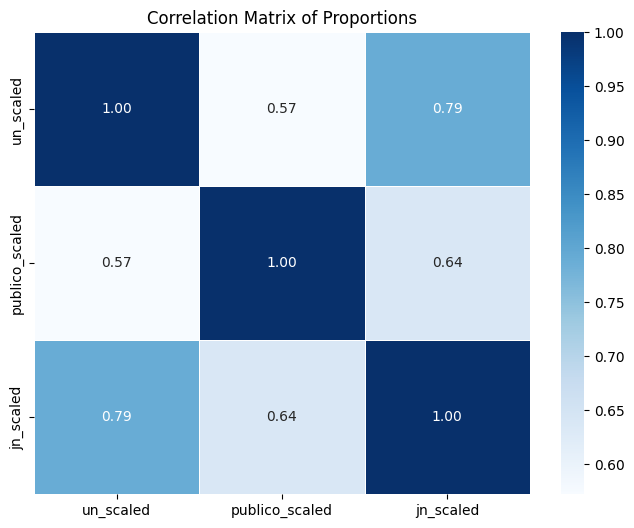

In [ ]:
# Calculate the correlation matrix for 'un', 'publico', and 'jn'
corr_matrix = df_terms[['un_scaled', 'publico_scaled', 'jn_scaled']].corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Proportions')
plt.show()

### Key Points Summary: **Portuguese Media (Stage 2)**

#### **Increasing Frequency of Key Terms**:
- Words like **"attack," "crisis," "violence,"** and **"war"** have become more frequent in recent years, reflecting heightened focus on conflict-related issues.

#### **Analysis of Major Portuguese Media Outlets**:
- The study examines two major outlets, **Público** and **JN (Jornal de Notícias)**, analyzing the frequency and context of terms related to **conflict and security**.

#### **Word Distribution Across Outlets**:
- Both outlets show similar patterns in the frequency of terms like **"attack," "crisis," "violence,"** and **"war"**, emphasizing shared attention to key conflict themes.

#### **Correlation with UN Peace and Security**:
- **JN**: Strong correlation (**0.8**) with **UN peace and security** topics, reflecting closer alignment with global narratives.  
- **Público**: Moderate correlation (**0.57**), indicating slightly less alignment with UN peace and security themes compared to JN.

This analysis highlights how Portuguese media, particularly **JN**, align with global discussions on peace and security while reflecting shared thematic focuses on conflicts and crises.

### Stage 2 Limitations

- **Data Availability**: Not all data for every year was accessible on **arquivo.pt**, especially from 2021 onwards. This limitation affected the completeness of the dataset, potentially skewing the analysis and introducing bias in the results for certain years.
  
- **Bias in Comparison**: The comparison could be biased because we are analyzing content across entire websites. Some of the keywords we focused on may appear in different sections of the media outlets (e.g., sports, entertainment, or economics) and may not always carry the same context or relevance as they would in the **UN Peace and Security** section of the UN website. This can lead to mismatches in context and may distort the true correlation between the media content and UN peace and security topics.